# Red threat summary

## Preliminary

In [1]:
# imports

# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from scipy.optimize import newton

from HANKStickyModel import HANKStickyModelClass

In [2]:
# solve example models

updated_par = {'phi_G': 0.4,         # mixed financing of fiscal policy shock
                'jump_eg': 0.01,    # 1% government spending shock
                'rho_eg': 0.9,
                'jump_em': 0.0,
                'taylor': 'linear'}
model = HANKStickyModelClass(name='baseline', par={**updated_par ,**{'inattention': 0.0}})
print("\r"+'Find steady state  ',end="")
model.find_ss(do_print=False)
# model without sticky information
print("\r"+'Compute Jacobians (no sticky) ',end="")
model.compute_jacs(do_print=False)
# print("\r"+'Find IRFs (no sticky)          ',end="")
# model.find_IRFs(do_print=False)

# model with sitcky information
model_sticky = model.copy() # steady state unaffected by sticky information
model_sticky.par.inattention = 0.935
print("\r"+'Compute Jacobians (sticky)    ',end="")
model_sticky.compute_jacs(do_print=False)
# print("\r"+'Find IRFs (sticky)               ',end="")
# model_sticky.find_IRFs(do_print=False)
print("\r"+'Done                     ',end="")

Done                     )    

# Research question:
How do sticky information for household affect the transmission of fiscal policy in a quantitative HANK model?

To answer the research question, I could motivate in the following steps:
1. Why sticky information?
2. Sticky information and interaction of fiscal policy.
3. Analysis of fiscal policy in a quantitative HANK with sticky information.

# 1. Motivating sticky information

- As Auclert, Rognlie, and Straub (2020) show, sticky information can help to match the sluggish response to aggregate shocks (macro moments) while matching the consumption response to this shock (micro moments). This helps to match the hump shaped response to a monetary policy shock, while matching iMPCs.

- In the thesis, I want to analyze how this information rigidity affects the transmission of fiscal policy shocks. For this I first need to establish how the sticky information affects the transmission of shocks.

## Sluggish response to transitory income shocks.

Sticky information reduces intertemporal substitution and income effects in response to a shock. For a household whose information have not adjusted, the reaction to a shock will then be delayed until he receives additional income. This leads to a hump shaped response in consumption.
This can be illustraded using the partial equilibrium response to persistent shocks of household inputs.

In [3]:
def plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho):

    nrows = len(compare_outputs)
    ncols = len(compare_inputs)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), dpi=100)

    fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

    return fig

def plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump=0.01, shocks_rho=0.9, shock_series=None, linestyle='-', decompose=False):

    fig_i = 0

    use_custom_series = True if isinstance(shock_series, np.ndarray) else False

    for output in compare_outputs:
        for i_s, shock in enumerate(compare_inputs):

            T = np.array([m.par.T for m in model_list]).min()
            if not use_custom_series:
                shock_series =  shocks_jump[i_s]*shocks_rho[i_s]**np.arange(T)

            ax = fig.axes[fig_i]
            fig_i += 1
            ax.set_title(f'{shock}_shock on {output} (in %)')

            for i_m, m in enumerate(model_list):
                jac = m.jac_hh[(output, shock)].copy()
                ss_value = m.ss.__dict__[output]
                IRF_abs = jac @ shock_series
                IRF_perc = (IRF_abs / ss_value) * 100
                # plot
                ax.plot(np.arange(plot_periods), IRF_perc[:plot_periods], label=label_list[i_m], linestyle=linestyle)
                if decompose:
                    decompose_PE(ax, jac, shock_series, ss_value, label_list[i_m], plot_periods)
            ax.legend()

    return fig

def decompose_PE(ax, jac, shock_series, ss_value, label, plot_periods):

    IRF = jac @ shock_series

    jac_no_intertemp = jac_hh_no_intertemp(jac.copy())
    IRF_no_intertemp = jac_no_intertemp @ shock_series
    ax.plot(np.arange(plot_periods), (IRF_no_intertemp[:plot_periods] / ss_value)*100, label=f"{label}: impact", linestyle="--")

    jac_no_anticip = jac_hh_no_anticipation(jac.copy())
    IRF_no_anticip = jac_no_anticip @ shock_series
    IRF_anticip = IRF - IRF_no_anticip
    ax.plot(np.arange(plot_periods), (IRF_anticip[:plot_periods] / ss_value)*100, label=f"{label}: anticipation", linestyle="--")

    IRF_distr = IRF_no_anticip - IRF_no_intertemp
    ax.plot(np.arange(plot_periods), (IRF_distr[:plot_periods] / ss_value)*100, label=f"{label}: distribution", linestyle="--")

    assert np.isclose(IRF - (IRF_no_intertemp + IRF_anticip + IRF_distr), 0.0).all()

def jac_hh_no_anticipation(jac):
    """Set elemets above diagonal to zero.
        The resulting Jacobian treats all shocks as completely unanticipated. This allows abstracting from intertemporal adjustments before a shock hits (i.e. income + substitution effect)"""
    T = jac.shape[0]
    for t in range(0,T-1):
        jac[t,t+1:] = 0.0
    return jac

def jac_hh_no_intertemp(jac):
    """ Sets all elements except the diagonal to zero. This mutes
        1. the response induced through a change in distribution that a shock in a previous period caused
        2. anticipation effects that cause intertemporal adjustments before the shock hits"""
    jac = np.diag(np.diag(jac))
    return jac

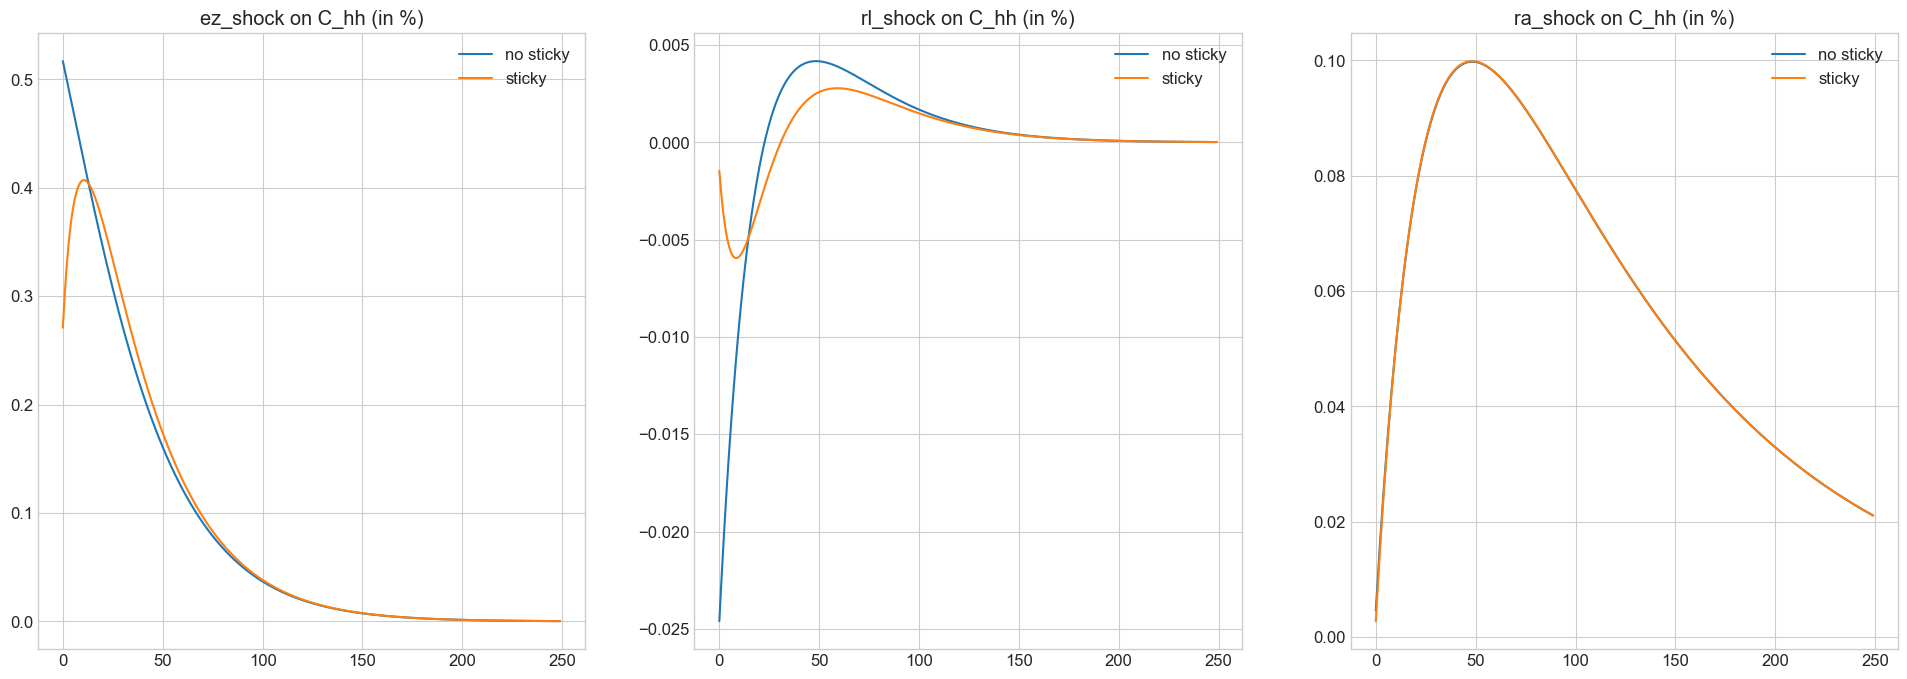

In [4]:
model_list = [model, model_sticky]
label_list = ['no sticky', 'sticky']

compare_outputs = ['C_hh']
compare_inputs = ['ez', 'rl', 'ra']
# compare_inputs = ['ez', 'tau', 'wN', 'rl', 'ra']

plot_periods = model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
shocks_rho =[0.966, 0.966, 0.966]
# shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
# shocks_rho =[0.966, 0.966, 0.966, 0.966, 0.966]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['no intertemp'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)


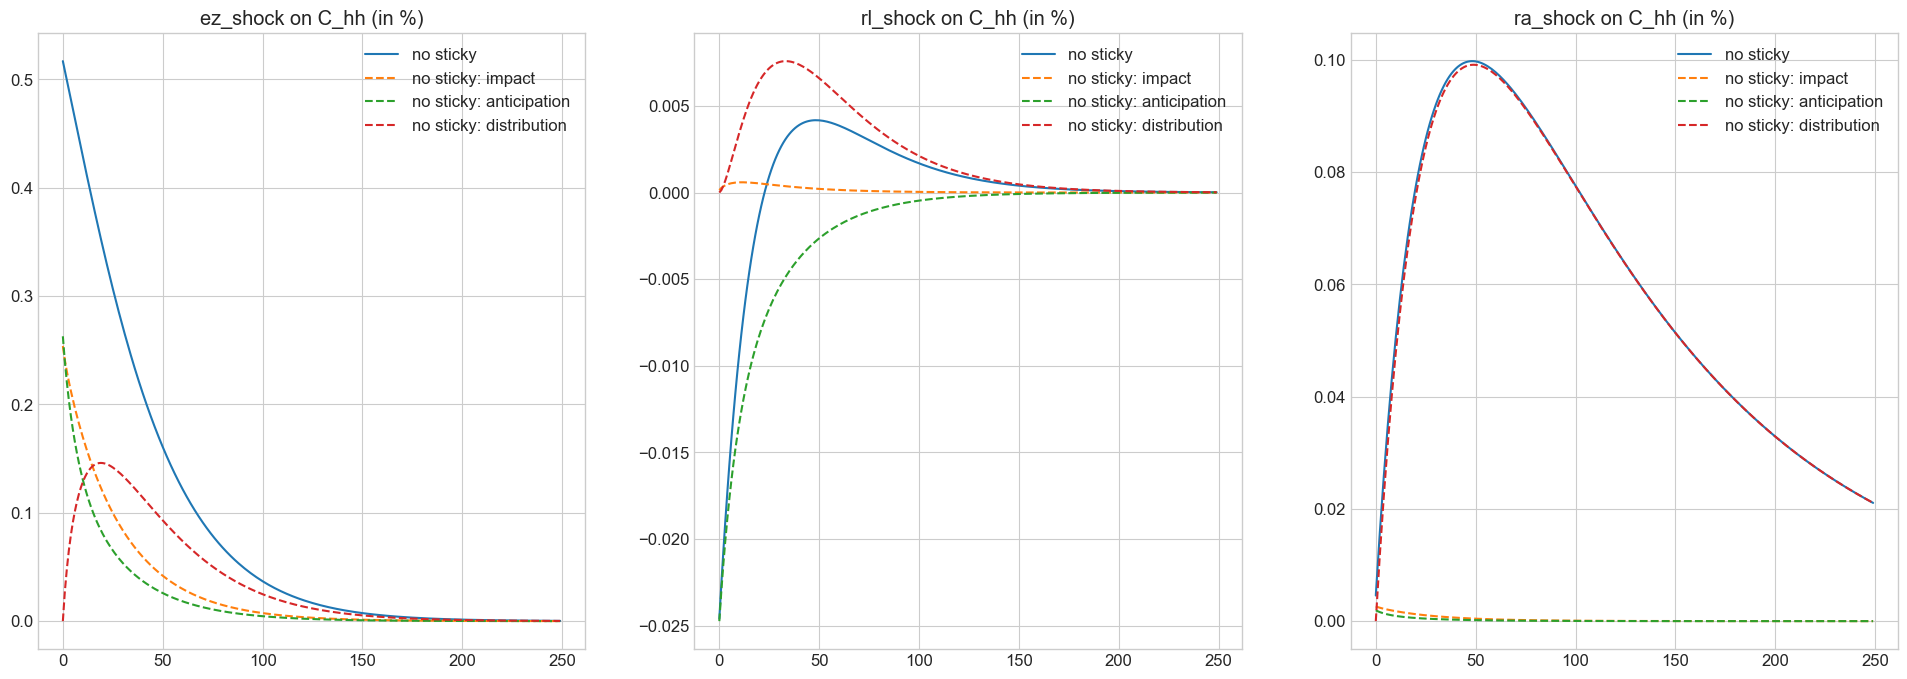

In [5]:
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), dpi=100)
fig = plotter_PE(fig, [model], ['no sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)

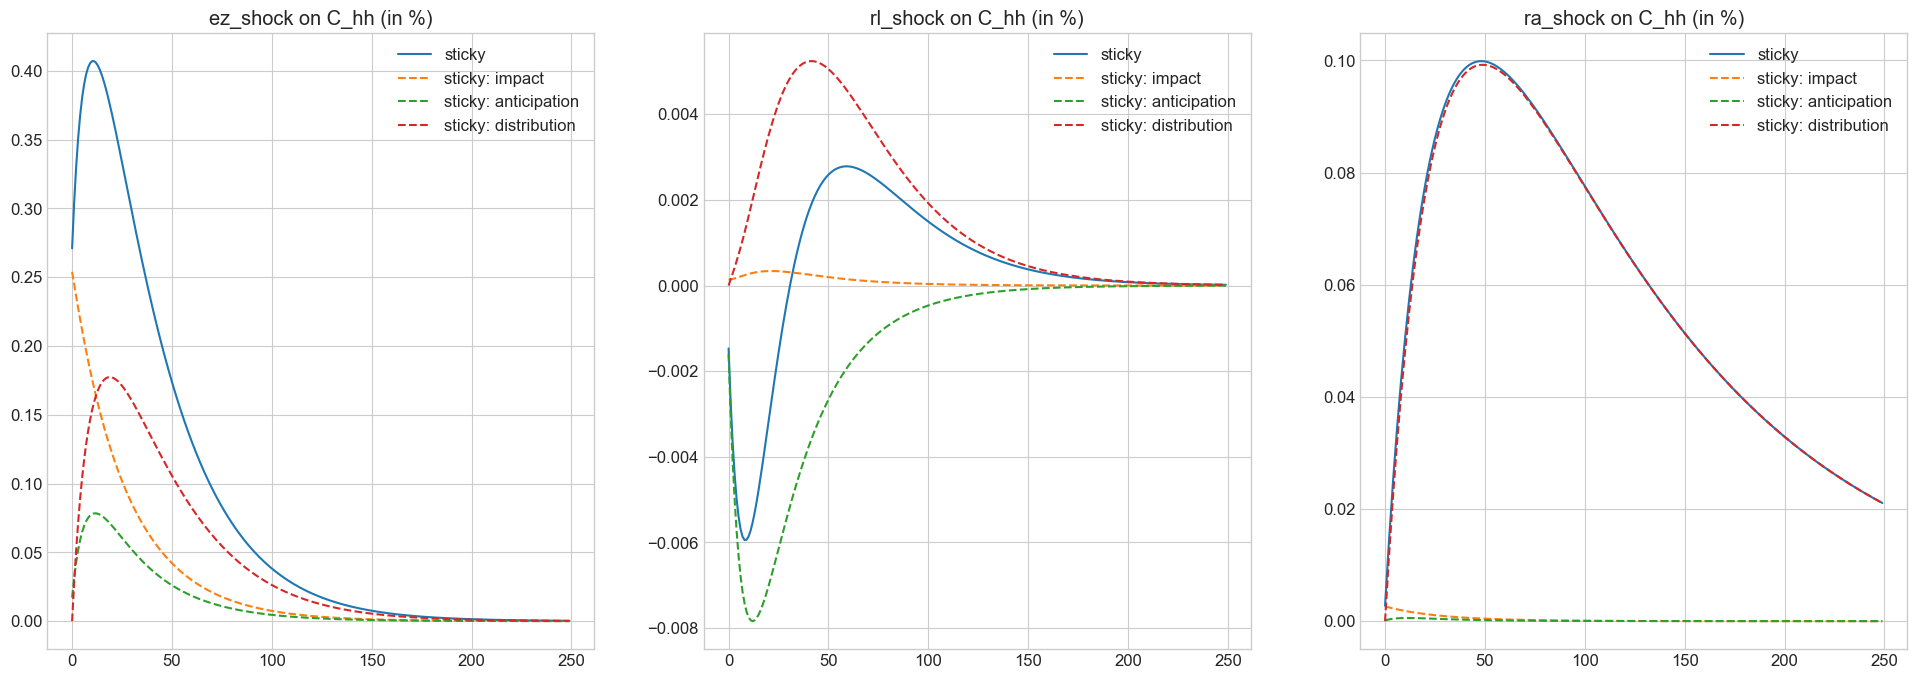

In [6]:
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], ['sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)

Sticky information effects are the same for ez, tau, wN shock:

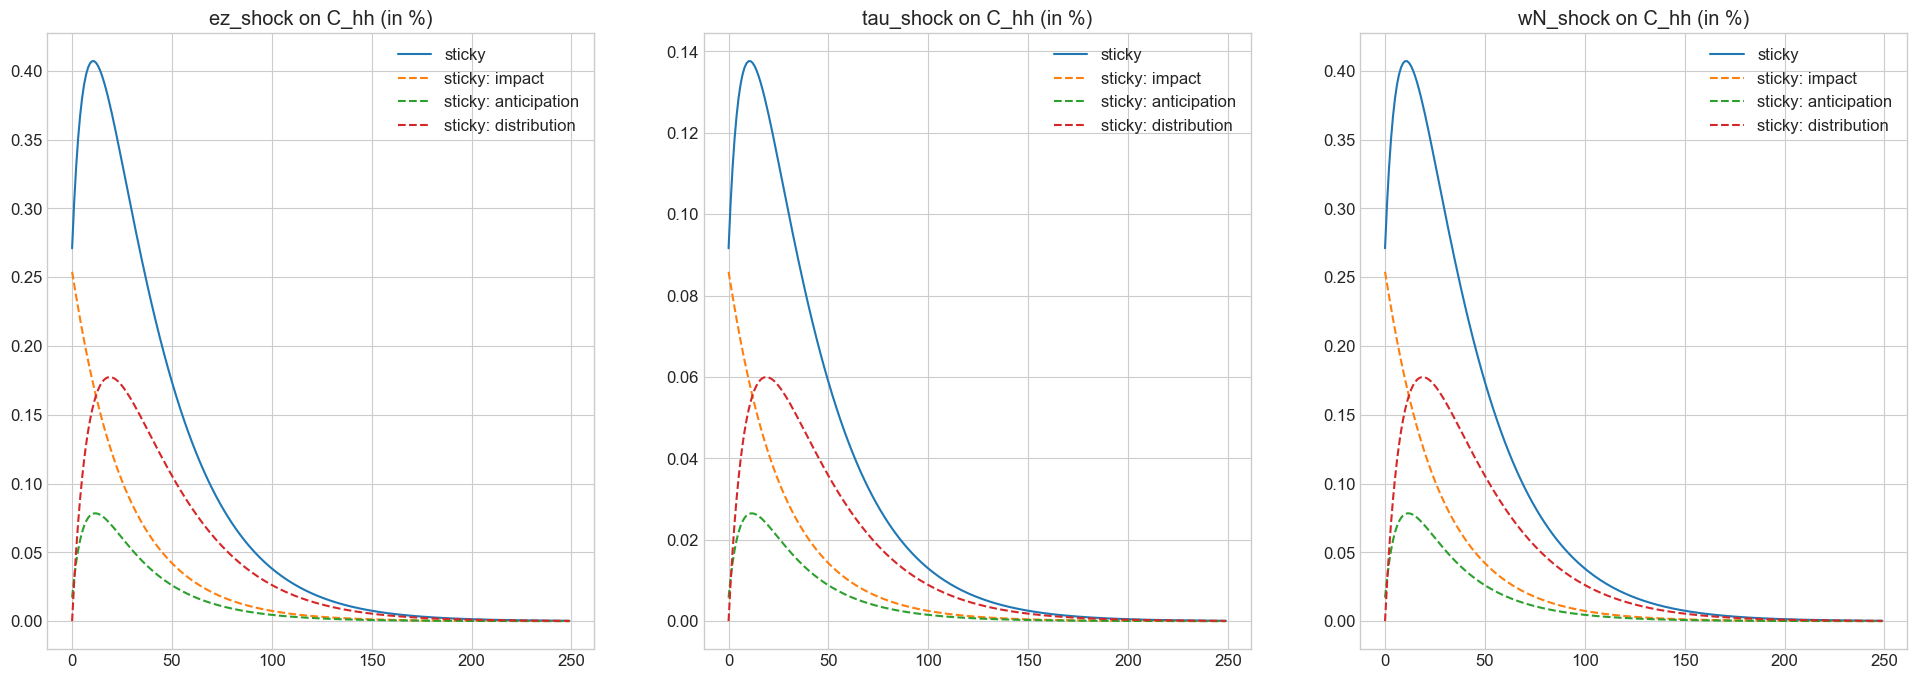

In [7]:
compare_outputs = ['C_hh']
compare_inputs = ['ez', 'tau', 'wN']

shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN]
shocks_rho =[0.966, 0.966, 0.966]
fig, axs = plt.subplots(nrows=len(compare_outputs), ncols=len(compare_inputs), figsize=(8*ncols, 8*nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], ['sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)

## Dependence of humps on inattention


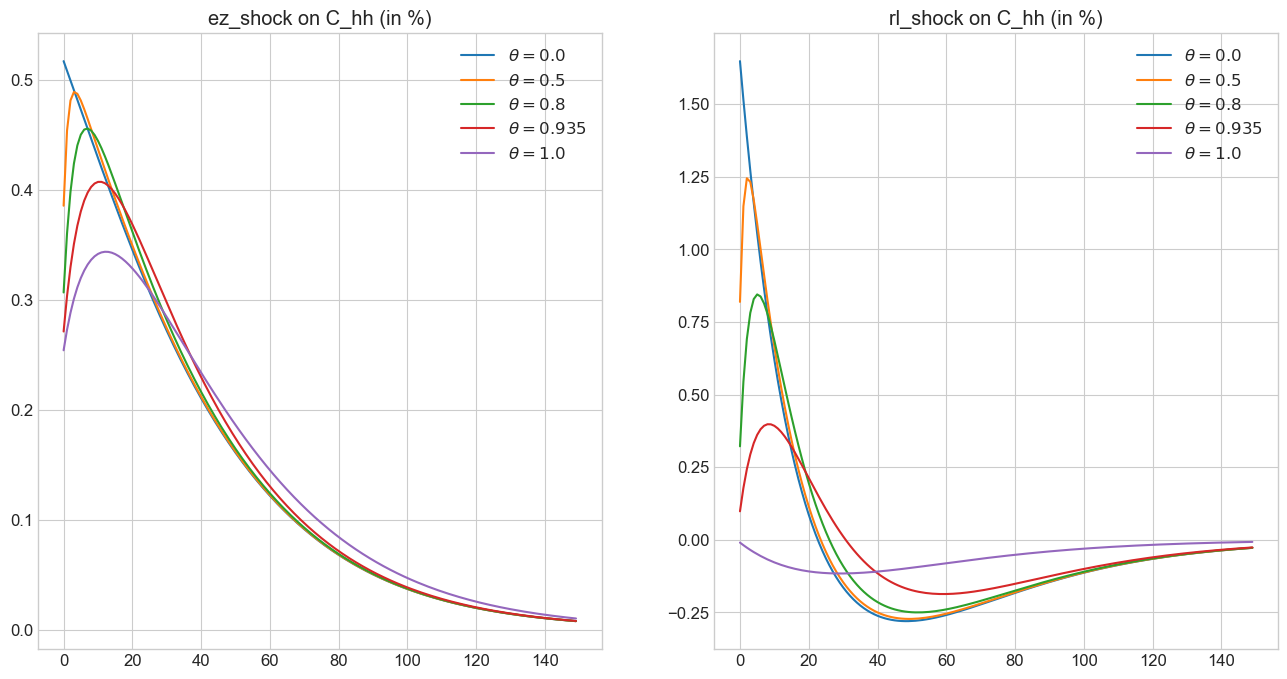

In [8]:
compare_outputs = ['C_hh']
compare_inputs = ['ez', 'rl']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 8*1), dpi=100)
for theta in [0.0, 0.5, 0.8, 0.935, 1.0]:
    model_temp = model.copy()
    model_temp.par.inattention = theta
    model_temp.jac_hh = model_temp._compute_sticky_jacs_hh(model_temp.jac_hh)
    fig = plotter_PE(fig, [model_temp], [f'$\\theta={theta}$'], compare_outputs, compare_inputs, 150, shocks_jump, shocks_rho, decompose=False)

## Dependence of humps on persistence
One important note is that the humps are highly dependent on the persistence of the shock. If the shocks are not highly persistent, income and substitution effects are muted and so is the impact of sticky information.

Illustration of this using different persistence levels that all increase labor income by 5% over different time horizons:

sum of shocks: 0.005
[0.95, 0.9, 0.8]
[0.00025, 0.0005, 0.001]
0.00014


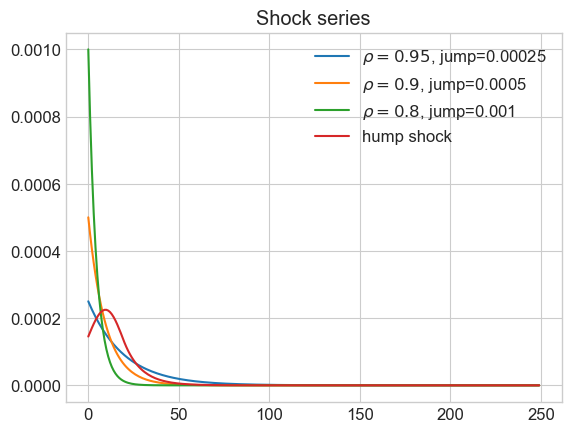

In [9]:
T = model.par.T
target = 0.005
print(f"sum of shocks: {target:.3f}")


def residual_jump(jump, *args):
    rho, target = args
    shock_series = jump*rho**np.arange(T)
    return abs(target - sum(shock_series))

def series_hump(T, jump):
    for t in range(T):
        if t < 20:
            rho = (110 - t) / 100
        else:
            rho = 0.9
        if t > 0:
            shock_lag = shock_series[t - 1]
        else:
            shock_lag = jump / 1.06
        shock_series[t] = shock_lag * rho
    return shock_series

def residual_hump(jump, *args):
    T, target = args
    shock_series = series_hump(T, jump)
    return abs(target - sum(shock_series))

rho = [0.95, 0.9, 0.8]


jump = [round(newton(residual_jump, 0.01, args=[r, target]),5) for r in rho]
print(rho)
print(jump)



fig, ax = plt.subplots()
ax.set_title("Shock series")
for i_r, r_i in enumerate(rho):
    shock_series = jump[i_r]*r_i**np.arange(T)
    ax.plot(np.arange(T),shock_series,label=f"$\\rho={r_i}$, jump={jump[i_r]}")

jump_hump = round(newton(residual_hump, 0.01, args=[T, target]),5)
print(jump_hump)
shock_series =  series_hump(T, jump_hump)
ax.plot(np.arange(T),shock_series,label=f"hump shock")

ax.legend()
plt.show()

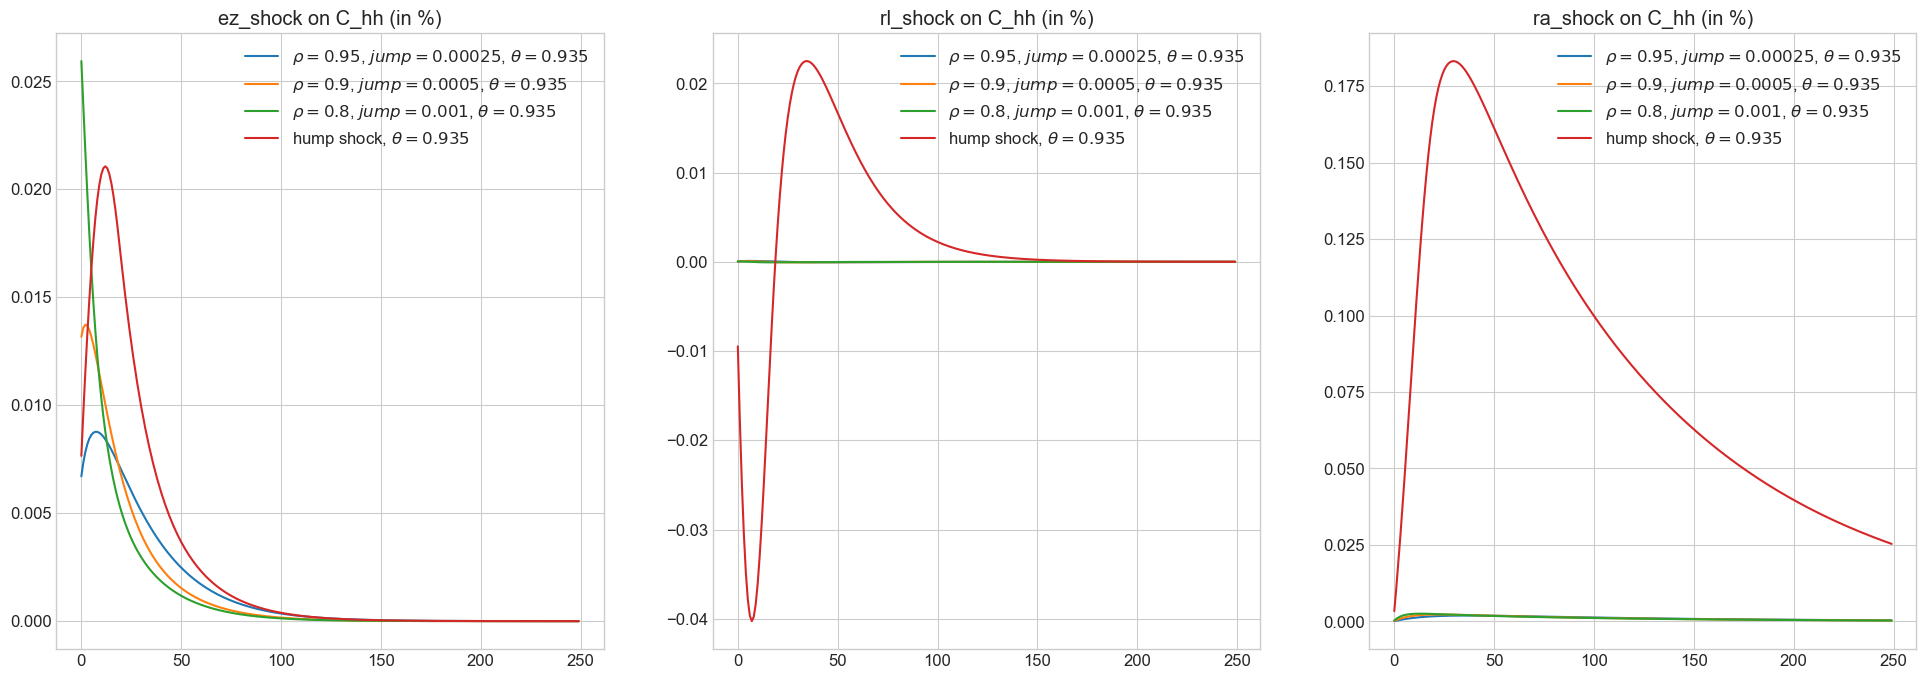

In [10]:
compare_outputs = ['C_hh']
compare_inputs = ['ez', 'rl', 'ra']

plot_periods = model.par.T

# 1 % shocks to ss
ss = model_sticky.ss

jump_init = jump[0]
shocks_jump = [jump_init * (1 - ss.tau) * ss.wN, jump_init * ss.rl, jump_init * ss.ra]
shocks_rho = [rho[0] for _ in range(3)]

fig = plot_PE_hh([model_sticky], [f'$\\rho={rho[0]}$, $jump={jump[0]}$, $\\theta={model_sticky.par.inattention}$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[1]
shocks_jump = [jump_init * (1 - ss.tau) * ss.wN, jump_init * ss.rl, jump_init * ss.ra]
shocks_rho = [rho[1] for _ in range(3)]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[1]}$, $jump={jump[1]}$, $\\theta={model_sticky.par.inattention}$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[2]
shocks_jump = [jump_init * (1 - ss.tau) * ss.wN, jump_init * ss.rl, jump_init * ss.ra]
shocks_rho = [rho[2] for _ in range(3)]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[2]}$, $jump={jump[2]}$, $\\theta={model_sticky.par.inattention}$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')


shock_series =  series_hump(T, jump_hump)
fig = plotter_PE(fig, [model_sticky], [f'hump shock, $\\theta={model_sticky.par.inattention}$'], compare_outputs, compare_inputs, plot_periods, shock_series=shock_series)


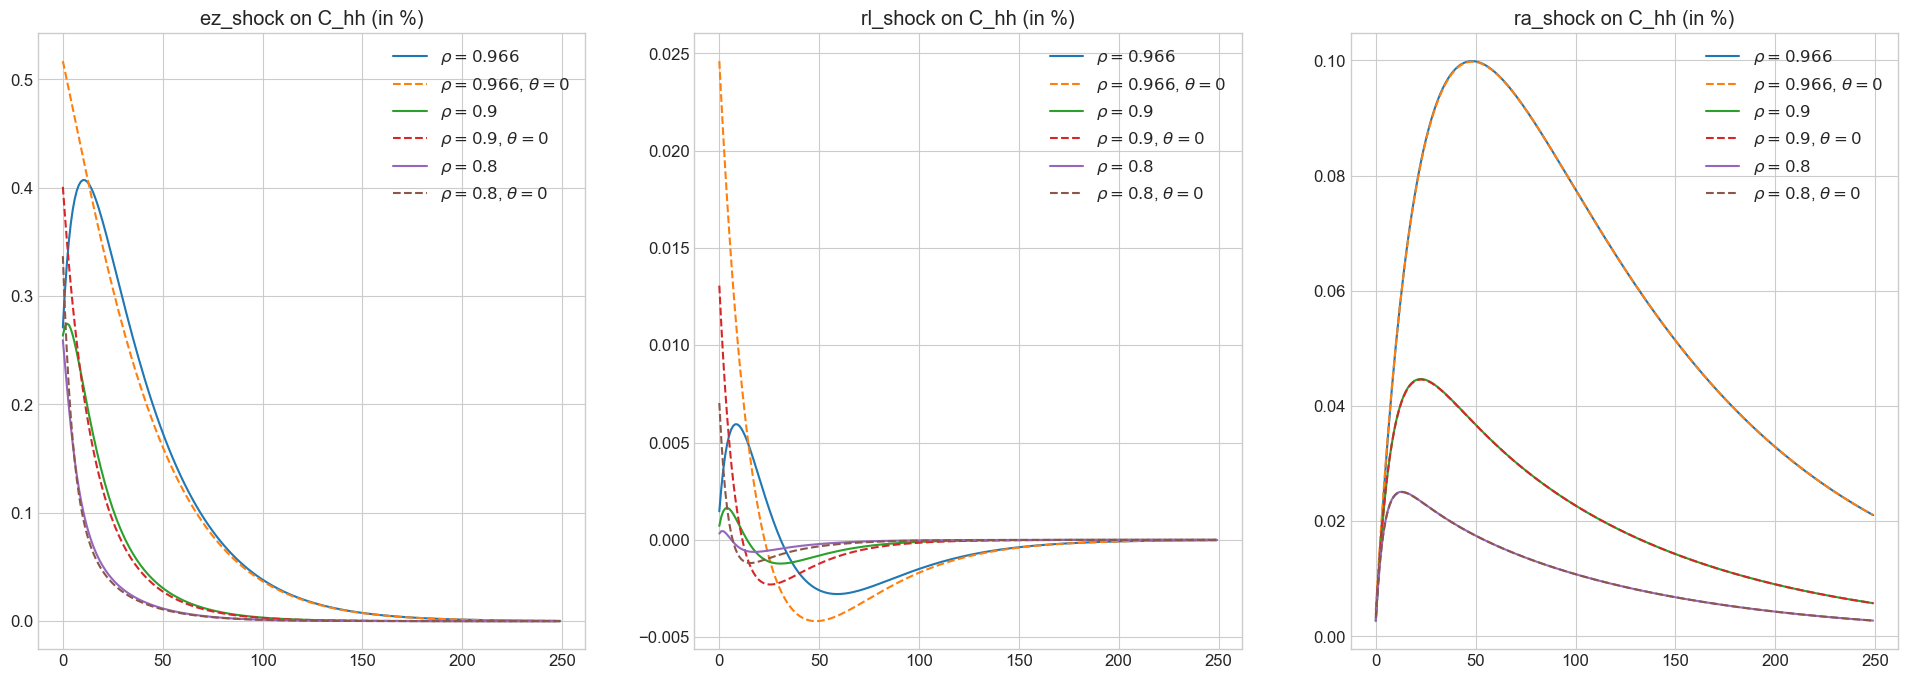

In [11]:
compare_outputs = ['C_hh']
compare_inputs = ['ez', 'rl', 'ra']

plot_periods = model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, 0.01 * ss.rl, 0.01 * ss.ra]
shocks_rho =[0.966, 0.966, 0.966]

fig = plot_PE_hh([model_sticky], ['$\\rho = 0.966$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

shocks_rho =[0.9, 0.9, 0.9]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.9$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')
# #
shocks_rho =[0.8, 0.8, 0.8]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.8$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')


For more details regarding the at the source of the sluggish response one can look at the household Jacobians.

In [12]:
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_jacs(model, s_list=None, dx=1e-4, inputs_outputs=[], max_T=model.par.T):
    """ compute and plot hh Jacobians with direct and fake news method
        - difference to GEModelTools function: plot only selected Jacobians.

        :param input_output: Jacobians to plot as list of elements in the form of ('outputname', 'inputname')."""

    model_jac_temp = deepcopy(model.jac_hh)    # save original model jacs and replace again later as not all Jacobians might be caluclated

    if s_list is None:
        s_list = list(np.arange(0, max_T, max_T // 4))

    print('note: differences should only be due to numerical errors\n')

    if model.par.inattention > 0:
        print(f'household inattention = {model.par.inattention}')
        print('-> sticky information jacs based on direct method correspond to the jacs without sticky information.')

    if len(inputs_outputs) > 0:
        inputs_hh_all = set([inp[1] for inp in plot_list if inp[1]])
    else:
        inputs_hh_all = model.inputs_hh_all

    # a. direct
    print('direct method:')
    model._compute_jac_hh(dx=dx, do_print=True, do_direct=True, s_list=s_list, inputs_hh_all=inputs_hh_all)
    jac_hh_direct = deepcopy(model.jac_hh)

    # b. fake news
    print(f'\nfake news method:')
    model._compute_jac_hh(dx=dx, do_print=True, do_direct=False, inputs_hh_all=inputs_hh_all)
    if model.par.inattention > 0:
        model.jac_hh = model._compute_sticky_jacs_hh(model.jac_hh)

    # c. compare

    def jac_add_subplot(input_output, n_inputs_outputs):
        jac_hh_var_direct = jac_hh_direct[input_output]
        jac_hh_var = model.jac_hh[input_output]

        ax = fig.add_subplot(n_inputs_outputs, 2, i * 2 + 1)
        ax_diff = fig.add_subplot(n_inputs_outputs, 2, i * 2 + 2)

        ax.set_title(f'Jac {input_output}')
        ax_diff.set_title(f'... difference (fake news - direct)')

        for j, s in enumerate(s_list):
            ax.plot(np.arange(max_T), jac_hh_var_direct[:max_T, s], color=colors[j], label=f'shock at {s}')
            ax.plot(np.arange(max_T), jac_hh_var[:max_T, s], color=colors[j], ls='--', label='fake news')

            diff = jac_hh_var[:max_T, s] - jac_hh_var_direct[:max_T, s]
            ax_diff.plot(np.arange(max_T), diff, color=colors[j])

            # print(f'{input_output}, s={s}')
            # print(f"max abs diff in consumption from one unit shock: {abs(diff).max()}")
            # print(f"in % from no sticky case: {abs(diff).max()/jac_hh_var_direct[abs(diff).argmax(), s]}")
            list_diffs.append([
                f'{input_output}, s={s}',
                abs(diff).max(),
                (abs(diff).max()/ abs(jac_hh_var_direct[abs(diff).argmax(), s])) * 100
            ])

        return ax

    list_diffs = [["Jac",
                  "max abs diff in C_hh from one unit shock",
                  "max % diff in C_hh from no sticky case"]]

    i = 0

    if len(inputs_outputs) == 0:
        fig = plt.figure(figsize=(6 * 2, len(model.outputs_hh) * len(model.inputs_hh_all) * 4), dpi=100)

        n_inputs_outputs = len(model.inputs_hh_all) * len(model.outputs_hh)
        for inputname in model.inputs_hh_all:
            for outputname in model.outputs_hh:

                input_output = (f'{outputname.upper()}_hh', inputname)

                ax = jac_add_subplot(input_output, n_inputs_outputs)

                if i == 0: ax.legend(frameon=True)
                i += 1
    else:
        fig = plt.figure(figsize=(6 * 2, len(inputs_outputs)*4), dpi=100)

        n_inputs_outputs = len(inputs_outputs)
        for input_output in inputs_outputs:

            ax = jac_add_subplot(input_output, n_inputs_outputs)

            if i == 0: ax.legend(frameon=True)
            i += 1

    model.jac_hh = model_jac_temp

    return list_diffs

note: differences should only be due to numerical errors

household inattention = 0.935
-> sticky information jacs based on direct method correspond to the jacs without sticky information.
direct method:
finding Jacobian wrt. ghost          : 0 3 7 20 40 [computed in 9.8 secs]
finding Jacobian wrt. rl             : 0 3 7 20 40 [computed in 6.9 secs]
finding Jacobian wrt. ez             : 0 3 7 20 40 [computed in 6.8 secs]
household Jacobian computed in 24.3 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for rl              in 3.3 secs
curly_Y and curly_D calculated for ez              in 3.2 secs
curly_E calculated in 2.0 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 9.0 secs


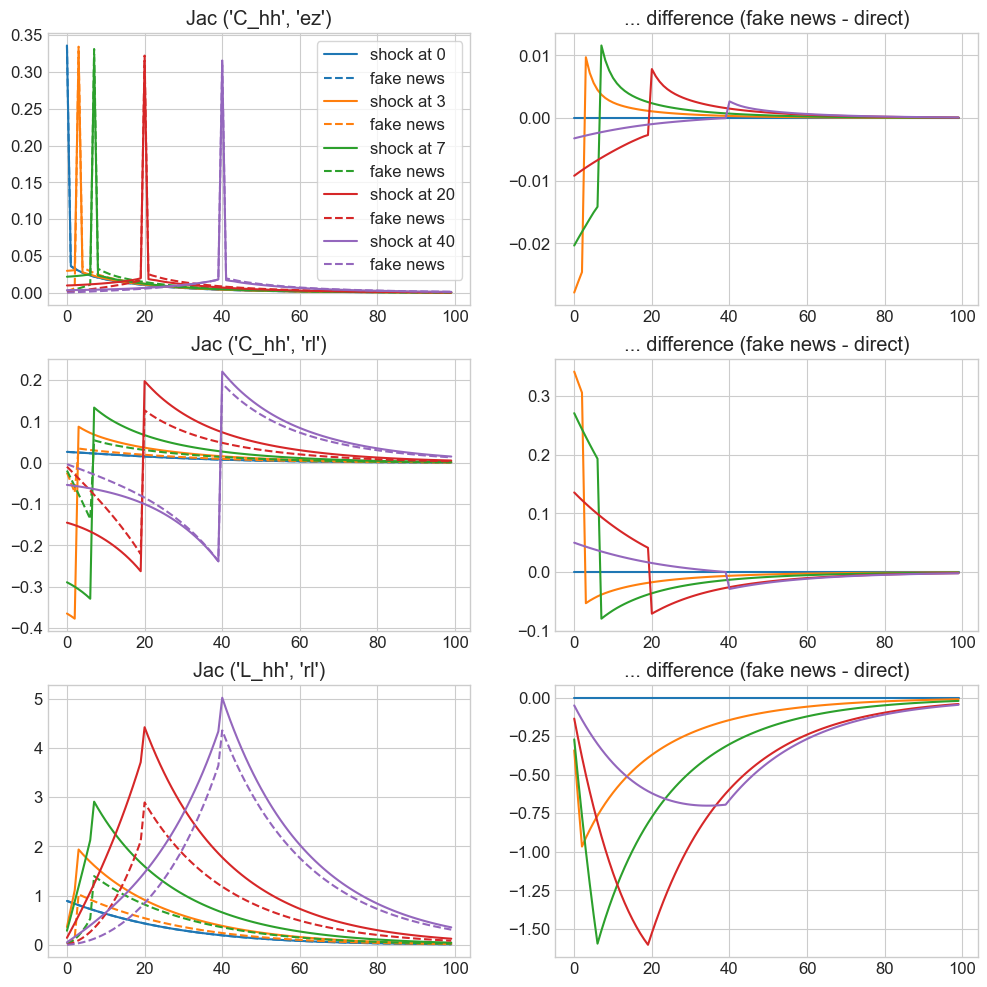

In [13]:
s_list = [0,3,7,20,40]
plot_list = [('C_hh', 'ez'),
             ('C_hh', 'rl'),
             ('L_hh', 'rl')]
list_diffs = plot_jacs(model_sticky, s_list=s_list, max_T=100, inputs_outputs=plot_list)

The table below is only a test. It mainly illustrates that in the case of a future shock, the difference in consumption depends on the level of inattention and that there is no difference if the shock is at s=0.

In [14]:
# differences in jacobians
pd.DataFrame(list_diffs[1:], columns=list_diffs[0]).round(3)

,Jac,max abs diff in C_hh from one unit shock,max % diff in C_hh from no sticky case
0,"('C_hh', 'ez'), s=0",0.000,0.000
1,"('C_hh', 'ez'), s=3",0.028,93.500
2,"('C_hh', 'ez'), s=7",0.020,93.500
3,"('C_hh', 'ez'), s=20",0.009,93.500
4,"('C_hh', 'ez'), s=40",0.003,93.500
5,"('C_hh', 'rl'), s=0",0.000,0.000
6,"('C_hh', 'rl'), s=3",0.341,93.500
7,"('C_hh', 'rl'), s=7",0.270,93.500
8,"('C_hh', 'rl'), s=20",0.136,93.500
9,"('C_hh', 'rl'), s=40",0.050,93.500


# 2. Sticky information and interaction with fiscal policy.

- Focus on interaction of fiscal policy household consumption as this is where sticky information interferes.

- In short, it is relevant to analyze the effect of sticky information in the context of fiscal policy as it alters the transmission of the fiscal policy through household consumption.


- Sticky information affects the consumption response through the delayed information arrival. Two main channels can be identified:
        1. The intertemporal substitution channel (changes trough different real interest rates).
        2. The redistribution channel (changes induces trough the redistribution caused by incomes and taxes)

- Depending on the fiscal policy setting, these channels can be differ in magnitude substantially. For instance, the degree of deficit financing changes how the tax rate adjusts.

Key part: Consumption decomposition.

The baseline shock has the following properties:

Shock properties
jump_eg = 0.01
rho_eg = 0.9
phi_G = 0.4
Monetary policy rule: linear

 Calculate IRFs
linear transition path found in 0.2 secs [finding solution matrix: 0.1 secs]
linear transition path found in 0.3 secs [finding solution matrix: 0.1 secs]


Text(0.5, 1.0, 'Fiscal policy shock trajectory')

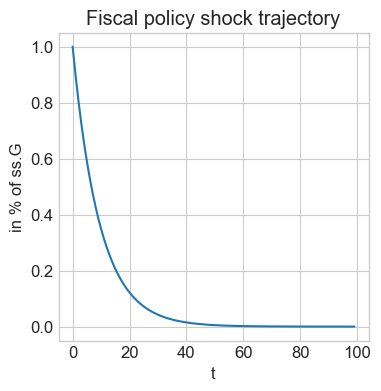

In [15]:
# shock properties
print("Shock properties")
properties = ['jump_eg', 'rho_eg', 'phi_G']
for p in properties:
    assert model_sticky.par.__dict__[p] == model.par.__dict__[p]
    print(f"{p} = {model.par.__dict__[p]}")
# assert other shocks are zero
for e in model.shocks:
    if 'eg' in  e: continue
    assert model_sticky.par.__dict__[f"jump_{e}"] == model.par.__dict__[f"jump_{e}"] if e != 'eg' else True
    assert model_sticky.par.__dict__[f"jump_{e}"] == 0.0 if e != 'eg' else True, f"jump_{e} = " + str(model_sticky.par.__dict__[f"jump_{e}"])

print(f"Monetary policy rule: {model.par.taylor}")

# calculate IRFs
print("\n Calculate IRFs")
model.find_IRFs(do_print=True)
model_sticky.find_IRFs(do_print=True)

assert (model.path.eg == model_sticky.path.eg).all()

# plot shock trajectory
T_max = 100
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.arange(T_max) ,model.path.eg[0,:T_max]*100)
ax.set_xlabel('t')
ax.set_ylabel('in % of ss.G')
ax.set_title('Fiscal policy shock trajectory')

## Consumption decomposition after a fiscal policy shock.
The consumption function for household can be expressed as $C_{t}=\mathcal{C}_{t}\left(\{r_{s}^{\ell},r_{s}^{a},Z_{s}\}\right)=\mathcal{C}_{t}\left(\{r_{s}^{\ell},r_{s}^{a},\tau_{s},w_{s},N_{s}\}\right)$ and decomposed into changes in the interest rates, taxes and pre-tax labor income.
$$dC_{t}=\sum_{s}\frac{\partial\mathcal{C}_{t}}{\partial r_{s}^{\ell}}dr_{s}^{\ell}+\sum_{s}\frac{\partial\mathcal{C}_{t}}{\partial r_{s}^{a}}dr_{s}^{a}+\sum_{s}\frac{\partial\mathcal{C}_{t}}{\partial\tau_{s}}d\tau_{s}+\sum_{s}\frac{\partial\mathcal{C}_{t}}{\partial w_{s}N_{s}}dw_{s}N_{s}$$

Note, that Hagedorn et al. (2019) introduces a decomposition of consumption that also considers the "direct" impact of government spending on household consumption, which describes the change in pre-tax labor income that results from the direct effect of government spending on aggregate demand. This is not considered yet.

In [16]:
def decompose_hh_path(model, output='c', do_print=False, use_inputs=None):
    """ decompose household transition path for consumption wrt. inputs or initial distribution
        --> in GEModelClass only in non-lin form?"""

    jac_hh = model.jac_hh
    IRF = model.IRF

    # a. set inputs and outputs

    assert output in model.outputs_hh
    Outputname_hh = f"{output.upper()}_hh"

    if use_inputs is None:
        use_inputs_list = []
    elif use_inputs == 'all':
        use_inputs_list = model.inputs_hh_all
    else:
        if isinstance(use_inputs, str):
            use_inputs_list = [use_inputs]
        else:
            use_inputs_list = use_inputs

    if do_print:
        print(f"inputs: {use_inputs_list}")

    # b. get consumption response
    pathvalue = np.zeros_like(IRF[Outputname_hh])
    for inputname in use_inputs_list:
        d_input = IRF[inputname]
        assert not np.isnan(d_input).any()
        assert not np.isnan(model.jac_hh[(Outputname_hh, inputname)]).any()
        pathvalue += jac_hh[(Outputname_hh, inputname)] @ d_input

    return pathvalue

In [17]:
def plot_decomposition(path_list, labels=[], output='c', T_max=None, diff=False):
    """ Plot decomposition of household consumption."""

    ncols = len(path_list)
    if diff and len(path_list)>2:
        print('Diff only possible for 2 models')
        diff = False
    elif diff:
        ncols += 1

    Outputname_hh = f"{output.upper()}_hh"
    assert all([Outputname_hh in p for path in path_list for p in path.keys()]), 'Output not in all decomposed paths'

    if T_max is None:
        T_max = min([p.shape[0] for path in path_list for p in path['C_hh'].values()])

    fig = plt.figure(figsize=(4*ncols, 6),dpi=100)
    i = 0
    for paths in path_list:
        ax = fig.add_subplot(1,ncols,i+1)
        if len(labels) == len(path_list):
            ax.set_title(labels[i],fontsize=14)

        for inputname in paths[Outputname_hh].keys():
            inputname_IRF = paths[Outputname_hh][inputname]
            ax.set_ylabel(f'% of s.s. {Outputname_hh}')
            ss_output = model.ss.__dict__[Outputname_hh]
            assert not np.isclose(ss_output, 0.0).any()
            ax.plot(np.arange(T_max), (inputname_IRF[:T_max]/ss_output) * 100,label=inputname)
        ax.legend()
        i += 1

    if diff:
        ax = fig.add_subplot(1,ncols,i+1)
        ax.set_title('diff',fontsize=14)
        for inputname in paths[Outputname_hh].keys():
            diff = path_list[0][Outputname_hh][inputname][:T_max] - path_list[1][Outputname_hh][inputname][:T_max]
            ax.plot(np.arange(T_max), diff,label=inputname)
        ax.legend()

In [18]:
decomp_path_no_sticky = {'C_hh': {}}
decomp_path_sticky = {'C_hh': {}}
for i in ['ra', 'rl', 'tau', 'wN', 'all']:
    print(f'input: {i}')
    decomp_path_no_sticky['C_hh'][str(i)] = decompose_hh_path(model,output='c',use_inputs=i,do_print=False)
    decomp_path_sticky['C_hh'][str(i)] = decompose_hh_path(model_sticky,output='c',use_inputs=i ,do_print=False)


input: ra
input: rl
input: tau
input: wN
input: all


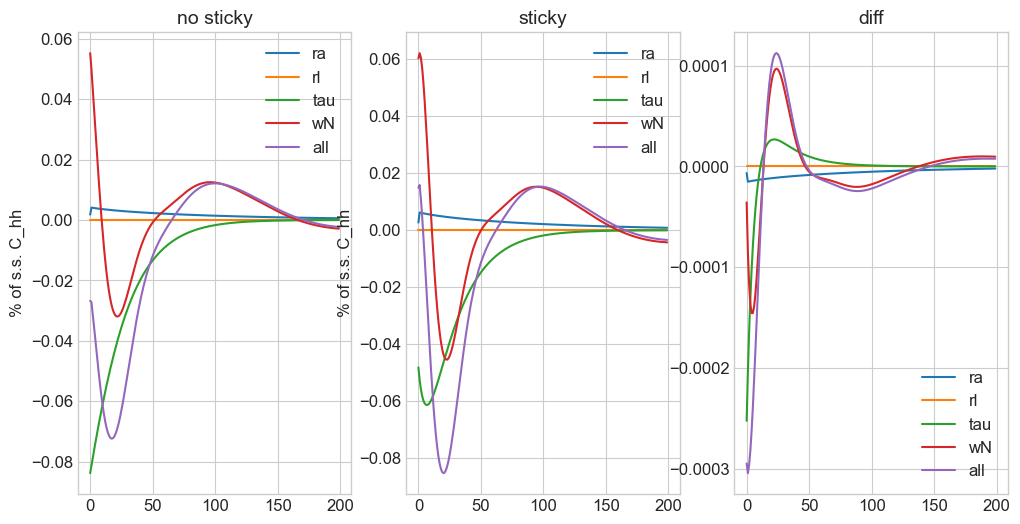

In [19]:
path_list = [decomp_path_no_sticky, decomp_path_sticky]
plot_decomposition(path_list, output='c', T_max=200, labels=['no sticky', 'sticky'], diff=True)

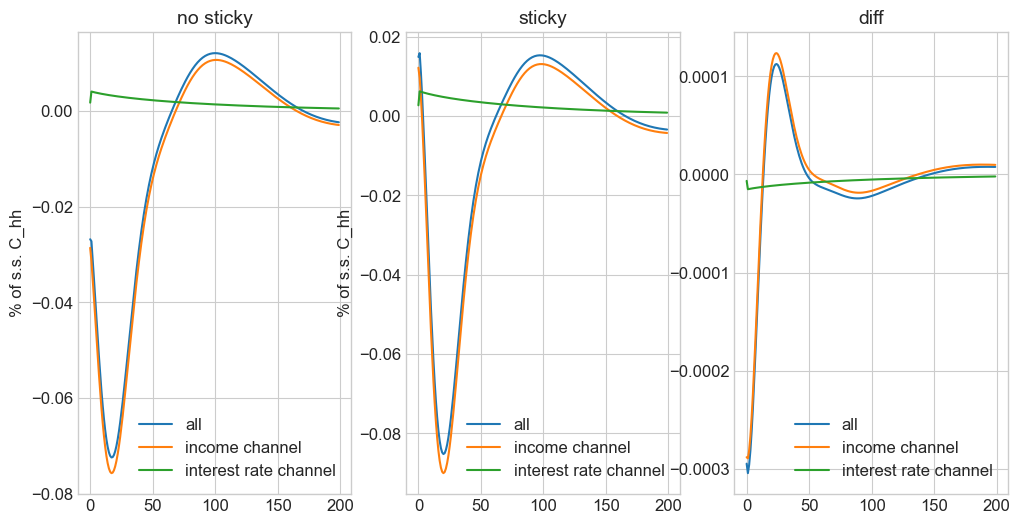

In [20]:
decomp_path_no_sticky = {'C_hh': {}}
decomp_path_sticky = {'C_hh': {}}
for i in ['ra', 'rl', 'tau', 'wN', 'all']:
    decomp_path_no_sticky['C_hh'][str(i)] = decompose_hh_path(model,output='c',use_inputs=i,do_print=False)
    decomp_path_sticky['C_hh'][str(i)] = decompose_hh_path(model_sticky,output='c',use_inputs=i ,do_print=False)


input_groups=[['tau', 'wN'], ['ra', 'rl']]
group_labels=['income channel', 'interest rate channel']

for i_group, group in enumerate(input_groups):
    group_name = group_labels[i_group]
    decomp_path_no_sticky['C_hh'][group_name] = np.zeros(model.par.T)
    decomp_path_sticky['C_hh'][group_name] = np.zeros(model_sticky.par.T)

    for varname in input_groups[i_group]:
        decomp_path_no_sticky['C_hh'][group_name] += decomp_path_no_sticky['C_hh'][varname]
        decomp_path_no_sticky['C_hh'].pop(varname)

        decomp_path_sticky['C_hh'][group_name] += decomp_path_sticky['C_hh'][varname]
        decomp_path_sticky['C_hh'].pop(varname)

path_list_groups = [decomp_path_no_sticky, decomp_path_sticky]
plot_decomposition(path_list_groups, output='c', T_max=200, labels=['no sticky', 'sticky'], diff=True)

Note that the sticky information even changes the sign of the consumption response!

# Analysis of fiscal policy settings

- This main analysis should provide the analysis of different fiscal policy settings. Key mechanisms should have been explained before.

- For each fiscal policy setting, I would like to report the following parts and compare the respective sticky vs. no-sticky information results:

    – Fiscal multiplier

    – (General equilibrium) Output decomposition
        - I think that the transmission channel of fiscal policy can be split into three channels:
        1. Direct demand channel: direct impact on demand and through that on other variables.
        2.  Indirect demand channel: indirect impact on demand through changes in household consumption and through that demand.
        3. Investment channel: impact through changes in investment demand and crowding-out

    – Consumption decomposition

## Equilibrium decomposition

###   Simple decomposition based on market clearing condition

In [21]:
def decompose_Y(model_list, label_list=[], plot_diff=False, set_jacs_zero=[]):
    """ decompose output in based on market clearing elements"""

    if plot_diff:
        assert len(model_list) == 2, 'Diff only available for two models atm.'
        decom_storage = [[],[]] # init storage to plot diffs

    n_plots = len(model_list) + 1 if plot_diff else len(model_list)

    fig = plt.figure(figsize=(4*n_plots,4))

    for i_model, model in enumerate(model_list):
        ax = fig.add_subplot(1,n_plots,i_model+1)

        if len(model_list) != len(label_list):
            model_name = model.name
        else:
            model_name = label_list[i_model]

        ax.set_xlabel('t')
        ax.set_ylabel('in % of ss.Y')
        ax.set_title(f'Output response decomposition for {model_name}')

        par = model.par

        for j in set_jacs_zero:
            assert j in model.jac.keys(), f'{j} not in jac.keys()'

        dY = np.zeros_like(model.IRF['Y'])
        inputs_good_market_clearing = ['C_hh', 'G', 'I', 'psi', 'L_hh']
        for varname in inputs_good_market_clearing:
            d_input = np.zeros_like(model.IRF[varname])
            for inputname in model.shocks + model.unknowns:
                # print(f"{(varname, inputname)}")
                if (varname, inputname) in set_jacs_zero:
                    # print(f"{(varname, inputname)} to zero")
                    d_input[:] += 0.0
                else:
                    d_input[:] += model.jac[(varname, inputname)] @ model.IRF[inputname]

            # assert (d_input == model.IRF[varname]).all(), f"{varname} max abs diff: {abs(d_input - model.IRF[varname]).max()}"

            if varname == 'L_hh':
                d_input[:] = par.xi * np.hstack((0.0, d_input[:-1]))

            dY += d_input
            ax.plot(np.arange(par.T), d_input/ss.Y, label=varname, linestyle='--')

            if plot_diff:
                decom_storage[i_model].append(d_input/ss.Y)

        ax.plot(np.arange(par.T), dY/ss.Y, label='Y', linestyle='-')
        ax.legend()

        if len(set_jacs_zero) == 0:
            assert np.isclose(dY, model.IRF['Y']).all()

        if plot_diff:
            decom_storage[i_model].append(dY/ss.Y)



    if plot_diff:
        ax = fig.add_subplot(1,n_plots,i_model+2)
        ax.set_xlabel('t')
        ax.set_ylabel('in % of ss.Y')
        ax.set_title(f'Output response decomposition diff')

        for i_v, varname in enumerate(inputs_good_market_clearing):
            ax.plot(np.arange(par.T), decom_storage[0][i_v] - decom_storage[1][i_v], label=varname, linestyle='--')
        ax.plot(np.arange(par.T), decom_storage[0][-1] - decom_storage[1][-1], label='Y', linestyle='-')
        ax.legend()



Schock eg has a non-zero trajectory.
Schock eg_direct has a non-zero trajectory.
Schock eg_distribution has a non-zero trajectory.
Schock eg_debt has a non-zero trajectory.


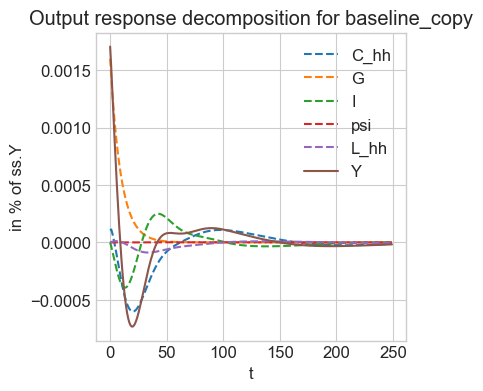

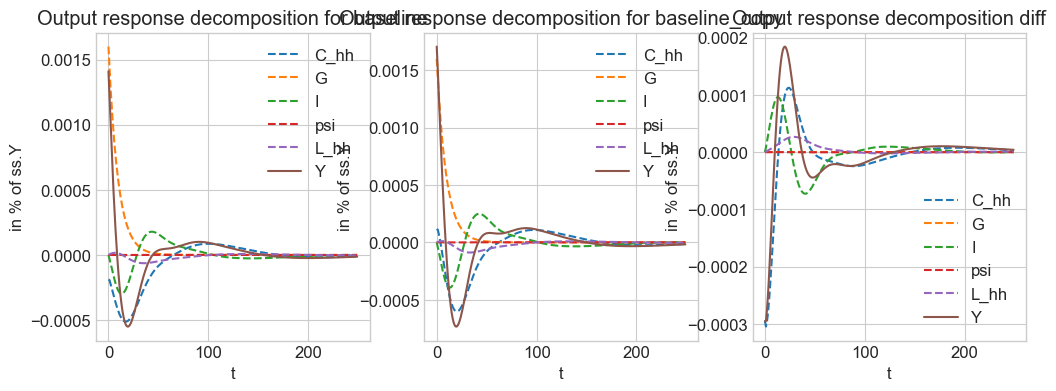

In [22]:
model_sticky.find_IRFs()

# for k in model.jac.keys():
#     if 'Y' == k[0]:
#         print(f"{k}, only zeros: {np.isclose(model.jac[k], 0.0).all()}")

for e in model.shocks:
    if not np.isclose(model.IRF[e], 0.0).all():
        print(f"Schock {e} has a non-zero trajectory.")

decompose_Y([model_sticky])

decompose_Y([model, model_sticky], plot_diff=True)

Problem with this decomposition:
It does not reflect the source of the respective changes.
If we look at the change in investment, this change in investment can have different sources:
1. Crowding out
2. Change in investment demand through higher output (which could come from the direct government spending effect on demand, the consumpton response, ...)
Given the simple decomposition based on the goods market clearing, we can not separate, where this effect comes from.

### General equilibrium decomposition

In [23]:
def decompose_GE(model, unkown: str, shock: str):

    par = model.par

    assert unkown in model.unknowns, 'Outputvariable needs to be an unkown'
    d_unkown = np.zeros_like(model.IRF[unkown])
    i_unknown = model.unknowns.index(unkown)

    assert shock in model.shocks, 'Shock not in model.shocks'
    d_shock = model.IRF[shock]
    i_shock = model.shocks.index(shock)
    # print(np.isclose(d_shock, 0.0).all())

    G_U_relevant = model.G_U[i_unknown*par.T:(i_unknown+1)*par.T, i_shock*par.T:(i_shock+1)*par.T]
    # print(np.isclose(G_U_relevant, 0.0).all())

    d_unkown += G_U_relevant @ d_shock

    return d_unkown

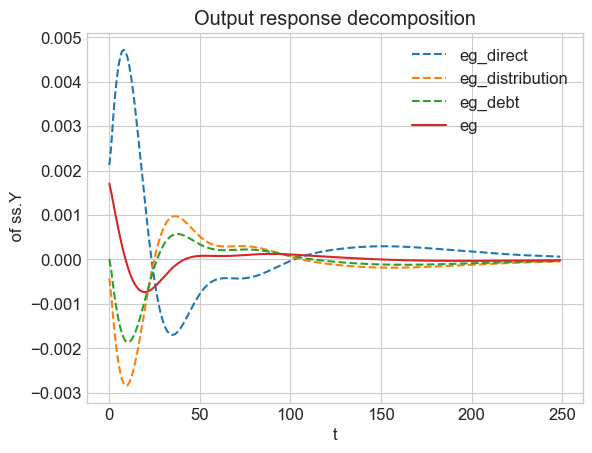

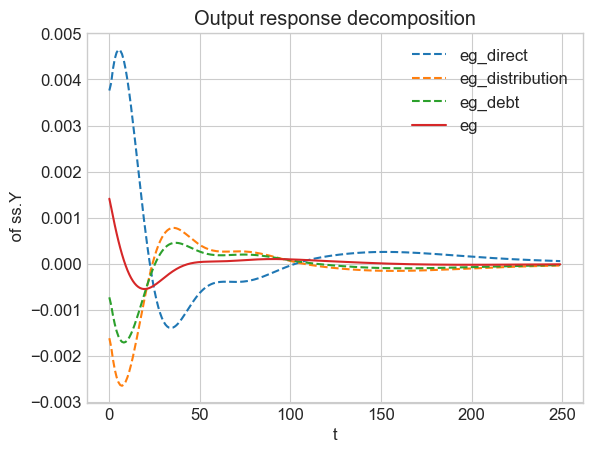

In [24]:
def plot_decomp_GE(model, unkown: str):
    par = model.par
    dU = np.zeros_like(model.IRF[unkown])
    fig, ax = plt.subplots()
    ax.set_xlabel('t')
    ax.set_ylabel(f' of ss.{unkown}')
    ax.set_title('Output response decomposition')
    for s in ['eg_direct', 'eg_distribution', 'eg_debt']:
        dU_from_ds = decompose_GE(model, unkown, s)
        dU += dU_from_ds
        ax.plot(np.arange(par.T), dU_from_ds, label=s, linestyle='--')
    assert(np.isclose(dU - model.IRF[unkown], 0.0).all())
    ax.plot(np.arange(par.T), dU, label='eg', linestyle='-')
    ax.legend()

plot_decomp_GE(model_sticky, 'Y')
plot_decomp_GE(model, 'Y')

I should be able to further decompose the anticipation effects, by shutting down inattention once and then compare it!

In [25]:
def plot_decomp_GE_diff(model_list, unkown: str):
    fig, ax = plt.subplots()

    ax.set_xlabel('t')
    ax.set_ylabel(f' of ss.{unkown}')
    ax.set_title('Output response decomposition diff')

    dU = [np.zeros_like(model_list[0].IRF[unkown]),
          np.zeros_like(model_list[0].IRF[unkown])]

    T = model_list[0].par.T
    for s in ['eg_direct', 'eg_distribution', 'eg_debt']:
        dU_from_ds_0 = decompose_GE(model_list[0], unkown, s)
        dU[0] += dU_from_ds_0

        dU_from_ds_1 = decompose_GE(model_list[1], unkown, s)
        dU[1] += dU_from_ds_1

        ax.plot(np.arange(T), dU_from_ds_0 - dU_from_ds_1, label=s, linestyle='--')

    ax.plot(np.arange(T), dU[0] - dU[1], label='eg', linestyle='-')
    ax.legend()

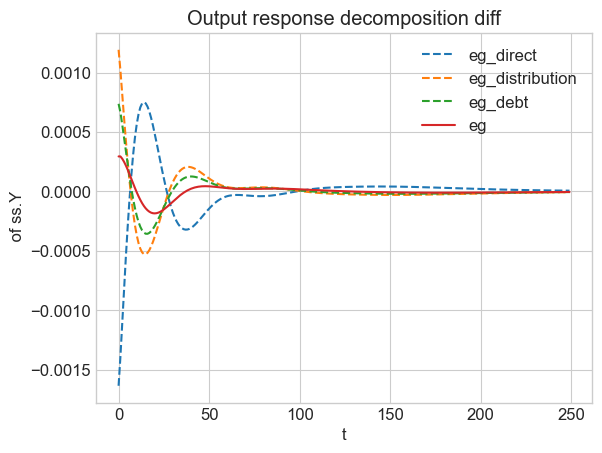

In [26]:
plot_decomp_GE_diff([model_sticky, model], unkown='Y')

Positive effect of sticky information wrt. eg_distribution and eg_debt, because intertemporal effect (only income effect with constant r) would lead to a decrease in consumption (e.g. anticipation of higher taxes -> lower consumption today).
Negative effect of sticky information wrt. eg_direct, because this would lead to a positive income effect which is not fully accounted for.
Change of sign after a certain period, because of the delayed impact.

## IRFs decomposition

In [27]:
model_eg_direct = model_sticky.copy()
model_eg_direct.par.jump_eg_distribution = 0.0
model_eg_direct.par.jump_eg_debt = 0.0
model_eg_direct.par.jump_eg = 0.0
model_eg_direct.find_IRFs()

model_eg_distribution = model_sticky.copy()
model_eg_distribution.par.jump_eg_direct = 0.0
model_eg_distribution.par.jump_eg_debt = 0.0
model_eg_distribution.par.jump_eg = 0.0
model_eg_distribution.find_IRFs()

model_eg_debt = model_sticky.copy()
model_eg_debt.par.jump_eg_direct = 0.0
model_eg_debt.par.jump_eg_distribution = 0.0
model_eg_debt.par.jump_eg = 0.0
model_eg_debt.find_IRFs()

### shocks ###


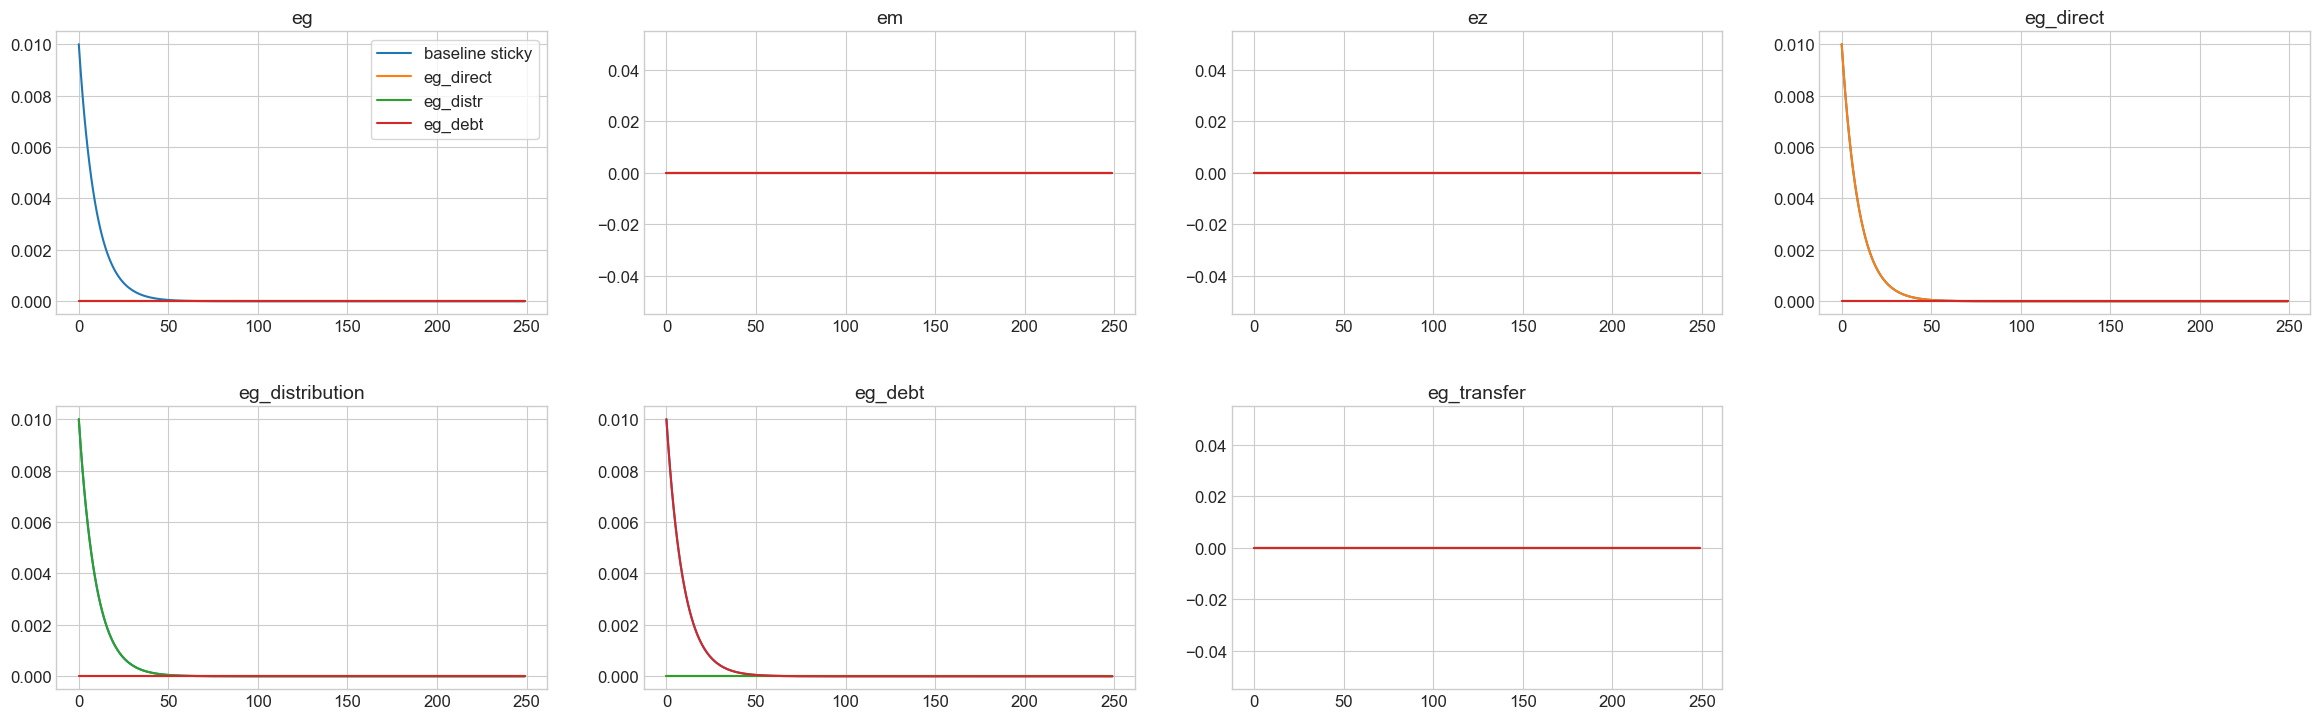


### varnames ###


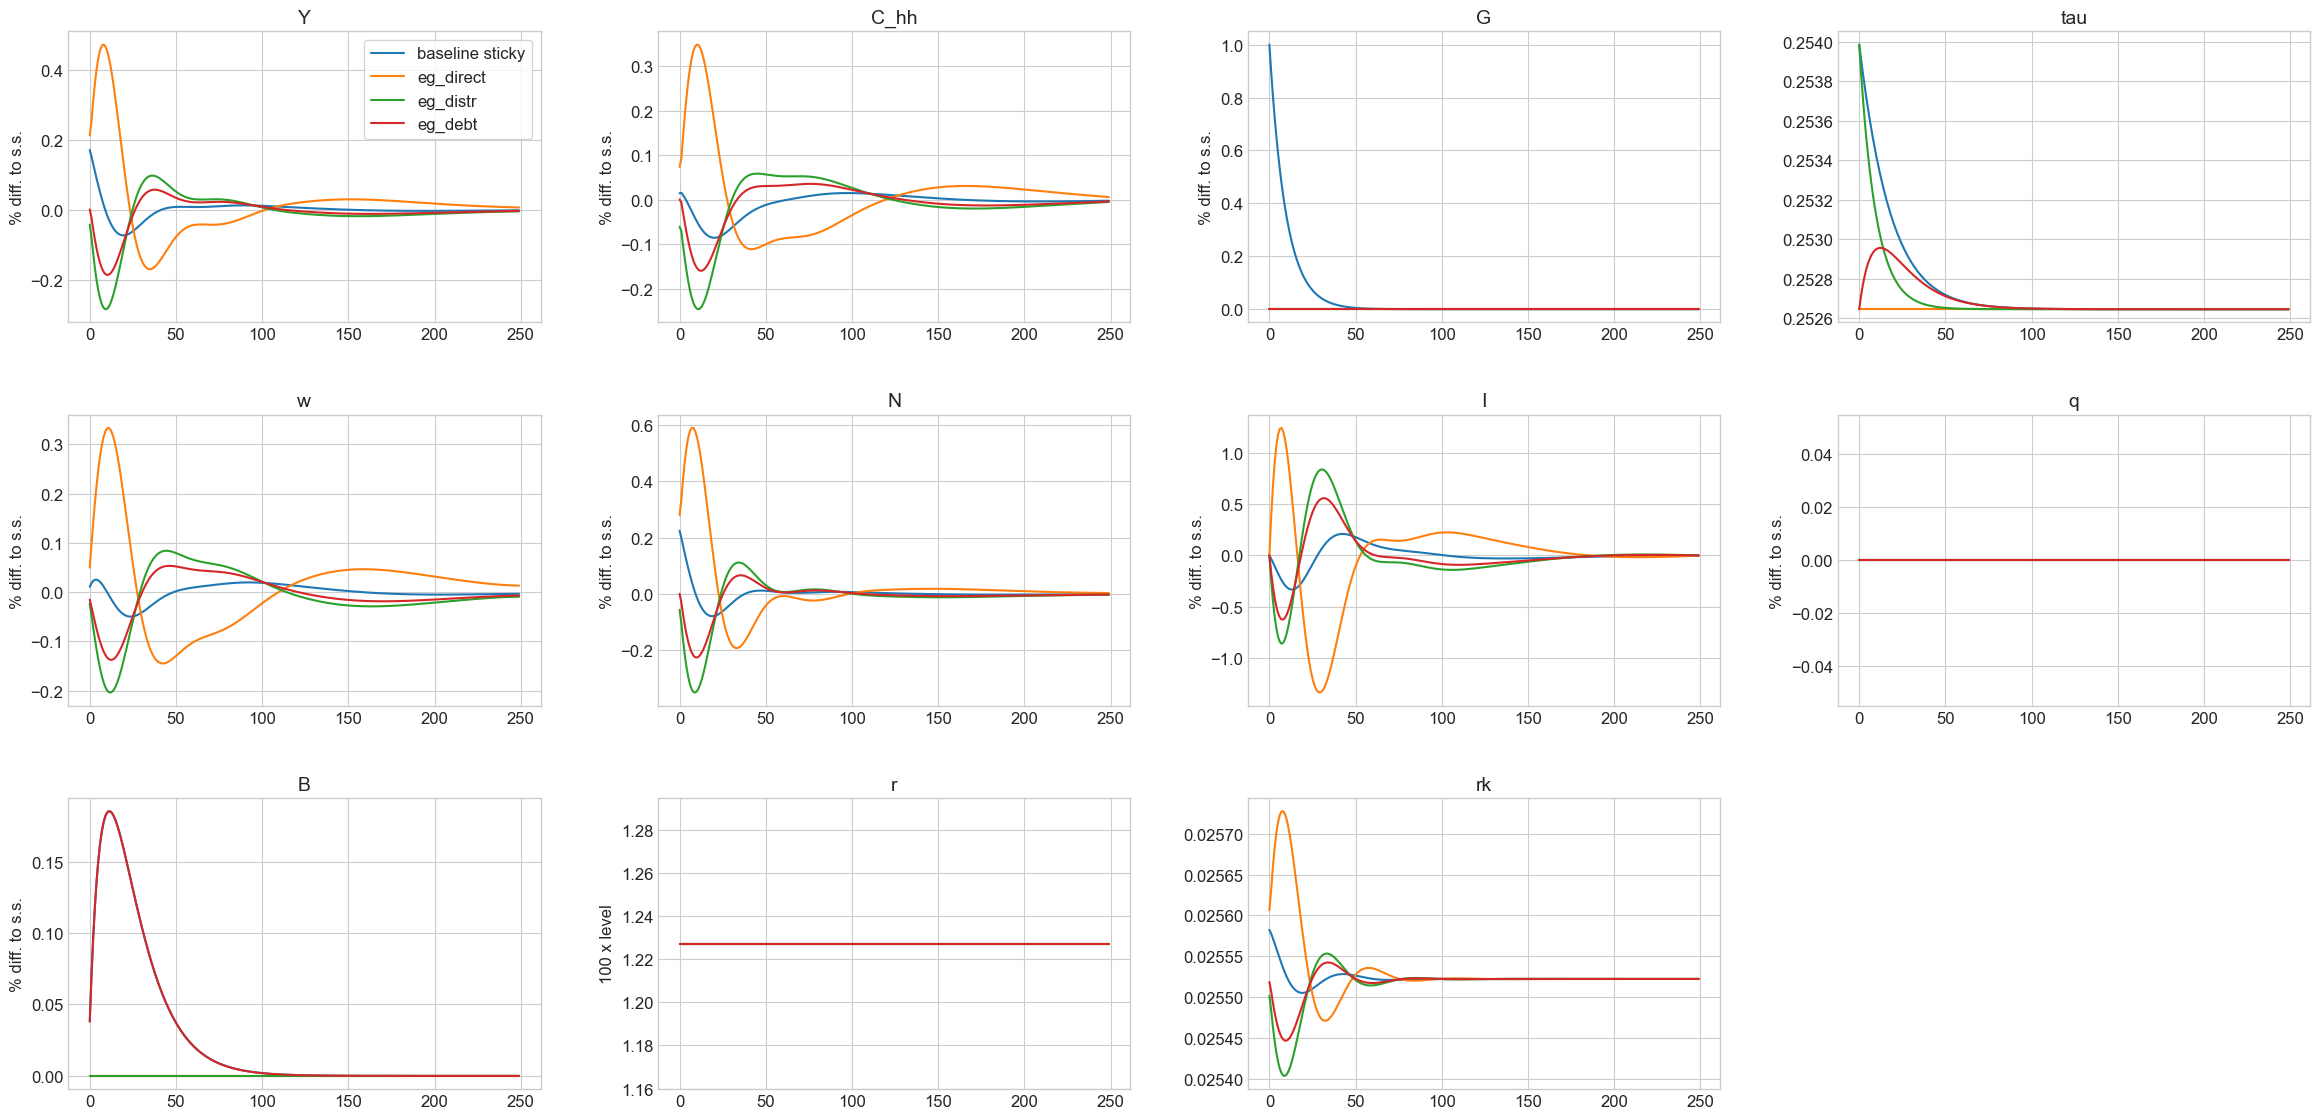

In [28]:
models = [model_sticky, model_eg_direct, model_eg_distribution, model_eg_debt]
labels = ['baseline sticky', 'eg_direct', 'eg_distr', 'eg_debt']
paths = ['Y', 'C_hh', 'G', 'tau', 'w', 'N', 'I', 'q', 'B', 'r', 'rk']
paths_short = ['Y', 'C_hh', 'G']
lvl_value = ['eg', 'eg_direct', 'eg_distribution', 'eg_debt', 'eg_transfer', 'ez', 'em',  'r', 'tau', 'rk']
facs = {'r':100}
model.compare_IRFs(models, labels, paths, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False)

# Fiscal Policy settings:


##  Fiscal Multiplier
Illustrate that the sticky information can have a substantial impact on the fiscal multiplier (a measure that is widely analyzed to measure the impact of fiscal policy in stimulating the economy).

In [29]:
def calc_FMP(model, cum_FMP_max_T=None):
    """Calculate fiscal multiplier"""

    ss = model.ss
    par = model.par
    IRF = model.IRF

    if cum_FMP_max_T == None:
        cum_FMP_max_T = model.par.T

    assert IRF['eg'].any(), 'No fiscal policy shocks specified'
    assert IRF['G'][0] != 0.0, 't=0, G == 0 -> divide error in fiscal multiplier'

    fmp_impact = IRF['Y'][0] / IRF['G'][0]

    dY = np.array([(1 + ss.r) ** (-t) * IRF['Y'][t] for t in range(par.T)])
    dG = np.array([(1 + ss.r) ** (-t) * IRF['G'][t] for t in range(par.T)])

    fmp_cum = dY[:cum_FMP_max_T].sum() / dG[:cum_FMP_max_T].sum()

    return fmp_impact, fmp_cum

In [30]:
# multipliers of models
fmp_impact_no_sticky, fmp_cumulative_no_sticky = calc_FMP(model)
_, fmp_cumulative_no_sticky_T_19 =calc_FMP(model, cum_FMP_max_T=19)
fmps_no_sticky = [fmp_impact_no_sticky, fmp_cumulative_no_sticky_T_19, fmp_cumulative_no_sticky]

fmp_impact_sticky, fmp_cumulative_sticky = calc_FMP(model_sticky)
_, fmp_cumulative_sticky_T_19 = calc_FMP(model_sticky, cum_FMP_max_T=19)
fmps_sticky = [fmp_impact_sticky, fmp_cumulative_sticky_T_19, fmp_cumulative_sticky]

labels = ['FMP impact', 'FMP cumulative (5 years)', 'FMP cumulative (full horizon)']
pd.DataFrame(data=[fmps_no_sticky, fmps_sticky], columns=labels, index=['no sticky', 'sticky'])

,FMP impact,FMP cumulative (5 years),FMP cumulative (full horizon)
no sticky,0.881671,0.241663,-0.011666
sticky,1.065944,0.317956,0.004964


## Tax financed shock

### varnames ###


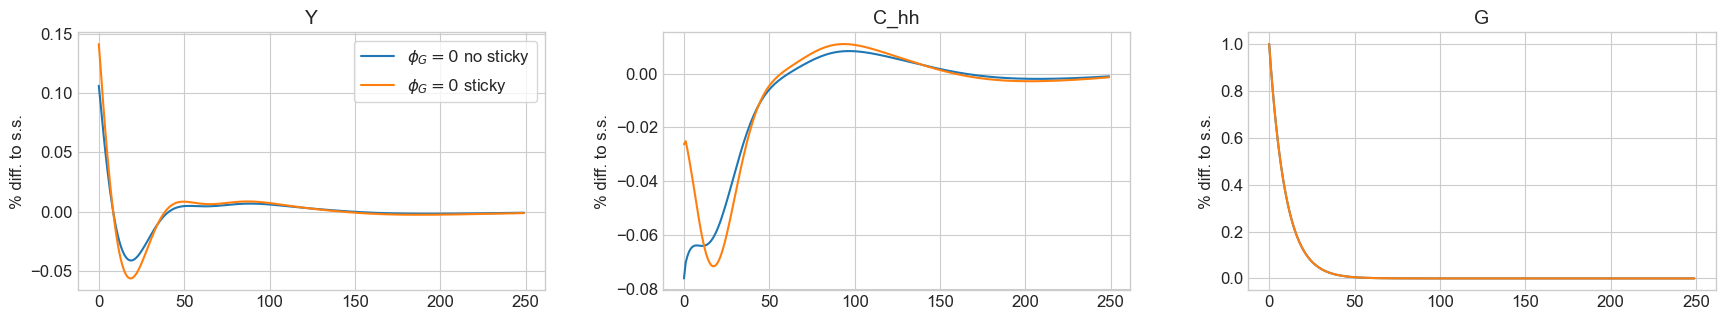

,FMP impact,FMP cumulative (5 years),FMP cumulative (full horizon)
no sticky,0.663907,0.165381,-0.000161
sticky,0.883892,0.214304,0.019330


In [31]:
model_sticky_tax = model_sticky.copy()
model_sticky_tax.par.phi_G = 0.0
model_sticky_tax.compute_jacs()
model_sticky_tax.find_IRFs()

model_no_sticky_tax = model.copy()
model_no_sticky_tax.par.phi_G = 0.0
model_no_sticky_tax.compute_jacs()
model_no_sticky_tax.find_IRFs()

labels = ['$\phi_G=0$ no sticky', '$\phi_G=0$ sticky']
models = [model_no_sticky_tax, model_sticky_tax]


model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False)

# multipliers of models
fmp_impact_no_sticky, fmp_cumulative_no_sticky = calc_FMP(model_no_sticky_tax)
_, fmp_cumulative_no_sticky_T_19 =calc_FMP(model_no_sticky_tax, cum_FMP_max_T=19)
fmps_no_sticky = [fmp_impact_no_sticky, fmp_cumulative_no_sticky_T_19, fmp_cumulative_no_sticky]

fmp_impact_sticky, fmp_cumulative_sticky = calc_FMP(model_sticky_tax)
_, fmp_cumulative_sticky_T_19 = calc_FMP(model_sticky_tax, cum_FMP_max_T=19)
fmps_sticky = [fmp_impact_sticky, fmp_cumulative_sticky_T_19, fmp_cumulative_sticky]

labels = ['FMP impact', 'FMP cumulative (5 years)', 'FMP cumulative (full horizon)']
pd.DataFrame(data=[fmps_no_sticky, fmps_sticky], columns=labels, index=['no sticky', 'sticky'])

### shocks ###


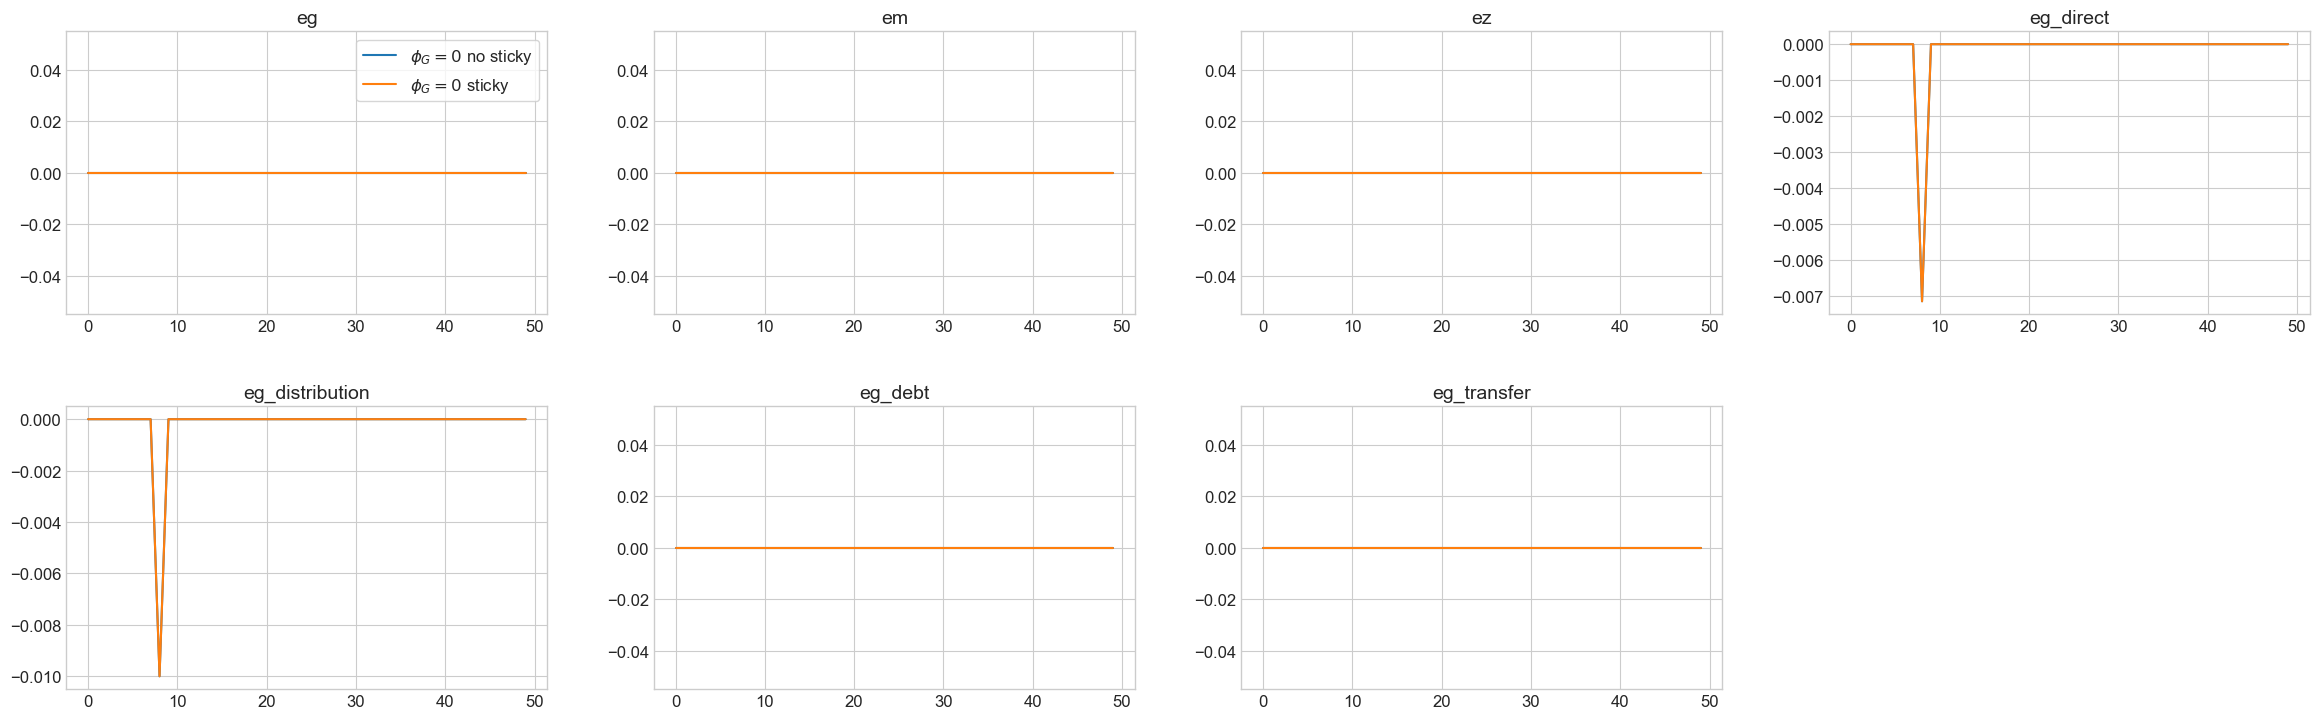


### varnames ###


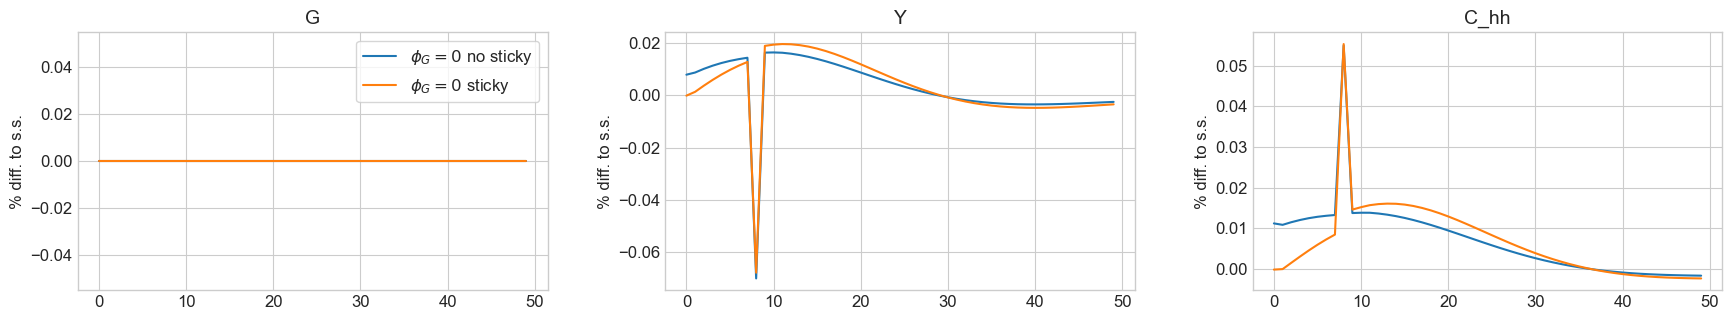

In [32]:
T = model.par.T
ss = model.ss
par = model.par
shock_T = 8
shock_specs = {
    'deg': np.zeros(T),
    'deg_distribution': np.zeros(T),
    'deg_debt': np.zeros(T),
    'deg_direct': np.zeros(T)}
# for s in shock_specs.keys():
#     shock_specs[s][shock_T] = -0.025
shock_specs['deg_distribution'][shock_T] = -0.01
shock_specs['deg_direct'][shock_T] = (ss.tau - 0.01) * (ss.w * ss.N) + ss.q * ss.B - (1 + par.delta_q * ss.q) * ss.B - ss.G

# model_sticky_tax = model_sticky.copy()
# model_sticky_tax.par.phi_G = 0.0
# model_sticky_tax.par.inattention = 0.975
# model_sticky_tax.compute_jacs()
model_sticky_tax.find_IRFs(shock_specs=shock_specs)

# model_no_sticky_tax = model.copy()
# model_no_sticky_tax.par.phi_G = 0.0
# model_no_sticky_tax.par.inattention = 0.0
# model_no_sticky_tax.compute_jacs()
model_no_sticky_tax.find_IRFs(shock_specs=shock_specs)

labels = ['$\phi_G=0$ no sticky', '$\phi_G=0$ sticky']
models = [model_no_sticky_tax, model_sticky_tax]

model.compare_IRFs(models, labels, ['G', 'Y', 'C_hh'], lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=True, T_max=50)

## Deficit financed shock

In [33]:
model_sticky_deficit = model_sticky.copy()
model_sticky_deficit.par.phi_G = 1.0
model_sticky_deficit.compute_jacs()
model_sticky_deficit.find_IRFs()

model_no_sticky_deficit = model.copy()
model_no_sticky_deficit.par.phi_G = 1.0
model_no_sticky_deficit.compute_jacs()
model_no_sticky_deficit.find_IRFs()

labels = ['$\phi_G=0$ no sticky', '$\phi_G=0$ sticky']
models = [model_no_sticky_deficit, model_sticky_deficit]

model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False)

# multipliers of models
fmp_impact_no_sticky, fmp_cumulative_no_sticky = calc_FMP(model_no_sticky_deficit)
_, fmp_cumulative_no_sticky_T_19 =calc_FMP(model_no_sticky_deficit, cum_FMP_max_T=19)
fmps_no_sticky = [fmp_impact_no_sticky, fmp_cumulative_no_sticky_T_19, fmp_cumulative_no_sticky]

fmp_impact_sticky, fmp_cumulative_sticky = calc_FMP(model_sticky_deficit)
_, fmp_cumulative_sticky_T_19 = calc_FMP(model_sticky_deficit, cum_FMP_max_T=19)
fmps_sticky = [fmp_impact_sticky, fmp_cumulative_sticky_T_19, fmp_cumulative_sticky]

labels = ['FMP impact', 'FMP cumulative (5 years)', 'FMP cumulative (full horizon)']
pd.DataFrame(data=[fmps_no_sticky, fmps_sticky], columns=labels, index=['no sticky', 'sticky'])

Traceback (most recent call last):
  File "C:\Users\Yannik\Meine Ablage\Uni\Master\Master Thesis\Thesis_Code\Hump_Jump_Replication\GEModelTools\GEModelClass.py", line 864, in _calc_jac_hh_fakenews
    dintertemps[varname] = stepvars_hh[varname] - one_step_ss[varname]
KeyboardInterrupt


KeyboardInterrupt: 

## Transfers

In [ ]:
model_eg_transfer = model_sticky.copy()
ss = model_eg_transfer.ss
model_eg_transfer.par.jump_eg_direct = 0.0
model_eg_transfer.par.jump_eg_distribution = 0.0
model_eg_transfer.par.jump_eg_debt = 0.0
# model_eg_transfer.par.jump_eg = 0.0
model_eg_transfer.par.jump_eg_transfer = 0.01 * (ss.G / ss.Y)
model_eg_transfer.par.rho_eg_transfer = 0.9
model_eg_transfer.find_IRFs()

model_eg_transfer_no_sticky = model.copy()
model_eg_transfer_no_sticky.par.jump_eg_direct = 0.0
model_eg_transfer_no_sticky.par.jump_eg_distribution = 0.0
model_eg_transfer_no_sticky.par.jump_eg_debt = 0.0
# model_eg_transfer_no_sticky.par.jump_eg = 0.0
model_eg_transfer_no_sticky.par.jump_eg_transfer = 0.01  * (ss.G / ss.Y)
model_eg_transfer_no_sticky.par.rho_eg_transfer = 0.9
model_eg_transfer_no_sticky.find_IRFs()

labels = ['eg_transfer no sticky', 'eg_transfer sticky']
models = [model_eg_transfer_no_sticky, model_eg_transfer]
paths = ['Y', 'C_hh', 'G', 'tau', 'wN', 'I']
paths_short = ['Y', 'C_hh', 'G']
lvl_value = ['eg', 'eg_direct', 'eg_distribution', 'eg_debt', 'eg_transfer', 'ez', 'em', 'r', 'tau', 'rk']
facs = {'r': 100}

model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False)

# multipliers of models
fmp_impact_no_sticky, fmp_cumulative_no_sticky = calc_FMP(model_eg_transfer_no_sticky)
_, fmp_cumulative_no_sticky_T_19 =calc_FMP(model_eg_transfer_no_sticky, cum_FMP_max_T=19)
fmps_no_sticky = [fmp_impact_no_sticky, fmp_cumulative_no_sticky_T_19, fmp_cumulative_no_sticky]

fmp_impact_sticky, fmp_cumulative_sticky = calc_FMP(model_eg_transfer)
_, fmp_cumulative_sticky_T_19 = calc_FMP(model_eg_transfer, cum_FMP_max_T=19)
fmps_sticky = [fmp_impact_sticky, fmp_cumulative_sticky_T_19, fmp_cumulative_sticky]

labels = ['FMP impact', 'FMP cumulative (5 years)', 'FMP cumulative (full horizon)']
pd.DataFrame(data=[fmps_no_sticky, fmps_sticky], columns=labels, index=['no sticky', 'sticky'])

# Other things:

1. Liquid wealth distribution
    My liquid wealth distribution is far from perfect. How much should I bother?

In [35]:
def plot_simul(model):

    par = model.par
    ss = model.ss

    fig = plt.figure(figsize=(16,4),dpi=100)

    fig.suptitle(f"Model: {model.name}")

    # a. income
    ax = fig.add_subplot(1,3,1)
    ax.set_title('productivity')
    ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2,3))))

    ax.set_xlabel('productivity, $z_{t}$')
    ax.set_ylabel('CDF')

    # b. liquid assets
    ax = fig.add_subplot(1,3,2)
    ax.set_title('savings (liquid asset)')
    ax.plot(np.insert(par.l_grid,0,par.l_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,3))),0,0.0),label='discrete')
    ax.set_xlabel('assets, $\ell\'_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')

    # c. illiquid assets
    ax = fig.add_subplot(1,3,3)
    ax.set_title('illiquid assets')
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,2))),0,0.0),label='discrete')
    ax.set_xlabel('assets, $a\'_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')

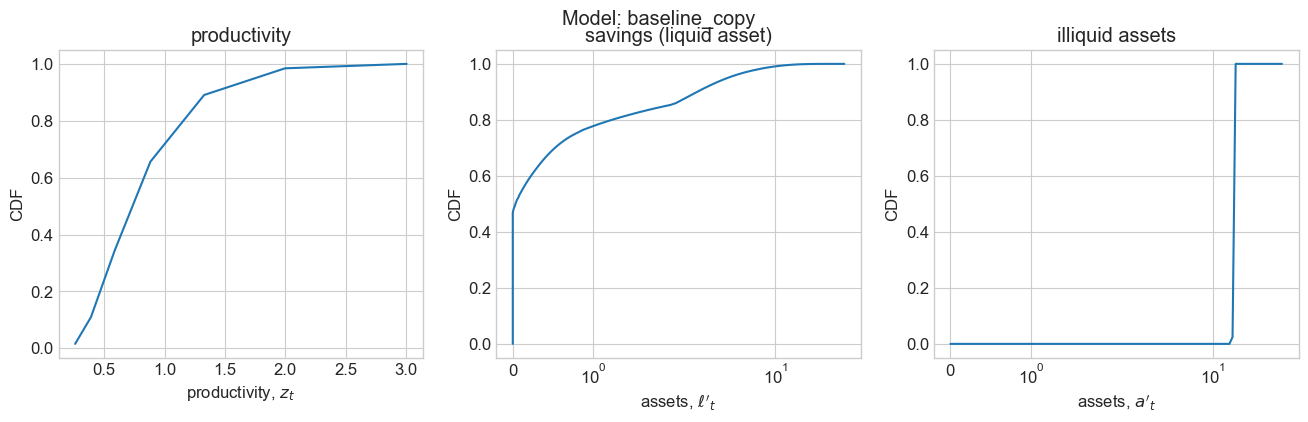

In [36]:
plot_simul(model_sticky)
# plot_simul(model_sticky)

IRF to different shock trajectory:

